In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from typing import Dict, List, Any 
from sklearn.model_selection import GridSearchCV
from pathlib import Path
warnings.filterwarnings('ignore')

# Load BASELINE datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

# Load CPU STRESS datasets
df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

# Load IO datasets
df_IO_block_latency = pd.read_csv("IO pressure/block_count_latency_device.csv")
df_IO_read_bytes = pd.read_csv("IO pressure/read_bytes.csv")
df_IO_write_bytes = pd.read_csv("IO pressure/write_bytes.csv")

# Load MEM STRESS datasets
df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")


# Load NET LOSS datasets
df_netloss_block_latency = pd.read_csv("net loss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("net loss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("net loss/write_bytes.csv")


# Add source labels - BASELINE
df_baseline_block_latency["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Add source labels - CPU STRESS
df_cpustress_block_latency["source"] = "CPU_STRESS"
df_cpustress_read_bytes["source"] = "CPU_STRESS"
df_cpustress_write_bytes["source"] = "CPU_STRESS"

# Add source labels - DELAY
df_IO_block_latency["source"] = "DELAY"
df_IO_read_bytes["source"] = "DELAY"
df_IO_write_bytes["source"] = "DELAY"

# Add source labels - MEM STRESS
df_memstress_block_latency["source"] = "MEM_STRESS"
df_memstress_read_bytes["source"] = "MEM_STRESS"
df_memstress_write_bytes["source"] = "MEM_STRESS"

# Add source labels - NET LOSS
df_netloss_block_latency["source"] = "NET_LOSS"
df_netloss_read_bytes["source"] = "NET_LOSS"
df_netloss_write_bytes["source"] = "NET_LOSS"


# Convert to datetime - BASELINE
df_baseline_block_latency["Time"] = pd.to_datetime(df_baseline_block_latency["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

# Convert to datetime - CPU STRESS
df_cpustress_block_latency["Time"] = pd.to_datetime(df_cpustress_block_latency["Time"])
df_cpustress_read_bytes["Time"] = pd.to_datetime(df_cpustress_read_bytes["Time"])
df_cpustress_write_bytes["Time"] = pd.to_datetime(df_cpustress_write_bytes["Time"])

# Convert to datetime - IO
df_IO_block_latency["Time"] = pd.to_datetime(df_IO_block_latency["Time"])
df_IO_read_bytes["Time"] = pd.to_datetime(df_IO_read_bytes["Time"])
df_IO_write_bytes["Time"] = pd.to_datetime(df_IO_write_bytes["Time"])

# Convert to datetime - MEM STRESS
df_memstress_block_latency["Time"] = pd.to_datetime(df_memstress_block_latency["Time"])
df_memstress_read_bytes["Time"] = pd.to_datetime(df_memstress_read_bytes["Time"])
df_memstress_write_bytes["Time"] = pd.to_datetime(df_memstress_write_bytes["Time"])

# Convert to datetime - NET LOSS
df_netloss_block_latency["Time"] = pd.to_datetime(df_netloss_block_latency["Time"])
df_netloss_read_bytes["Time"] = pd.to_datetime(df_netloss_read_bytes["Time"])
df_netloss_write_bytes["Time"] = pd.to_datetime(df_netloss_write_bytes["Time"])


delay = 30
duration = 50

# Synchronize all datasets with baseline timeline
time_offset = df_baseline_block_latency["Time"].min()

# Synchronize CPU STRESS datasets
cpustress_offset = time_offset - df_cpustress_block_latency["Time"].min()
df_cpustress_block_latency["Time"] += cpustress_offset
df_cpustress_read_bytes["Time"] += cpustress_offset
df_cpustress_write_bytes["Time"] += cpustress_offset

# Synchronize DELAY datasets
delay_offset = time_offset - df_IO_block_latency["Time"].min()
df_IO_block_latency["Time"] += delay_offset
df_IO_read_bytes["Time"] += delay_offset
df_IO_write_bytes["Time"] += delay_offset

# Synchronize MEM STRESS datasets
memstress_offset = time_offset - df_memstress_block_latency["Time"].min()
df_memstress_block_latency["Time"] += memstress_offset
df_memstress_read_bytes["Time"] += memstress_offset
df_memstress_write_bytes["Time"] += memstress_offset

# Synchronize NET LOSS datasets
netloss_offset = time_offset - df_netloss_block_latency["Time"].min()
df_netloss_block_latency["Time"] += netloss_offset
df_netloss_read_bytes["Time"] += netloss_offset
df_netloss_write_bytes["Time"] += netloss_offset


# Convert timeline to minutes for ALL datasets
all_dfs = [
    # Baseline
    df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
    # CPU Stress
    df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
    # Delay
    df_IO_block_latency, df_IO_read_bytes, df_IO_write_bytes,
    # Memory Stress
    df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
    # Network Loss
    df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE DATASETS DICTIONARY 
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'IO pressure': df_IO_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'IO pressure': df_IO_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'IO pressure': df_IO_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

print("✅ All I/O datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} I/O metrics across {len(all_datasets['BlockLatency'])} experiment types")
print("\nDataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

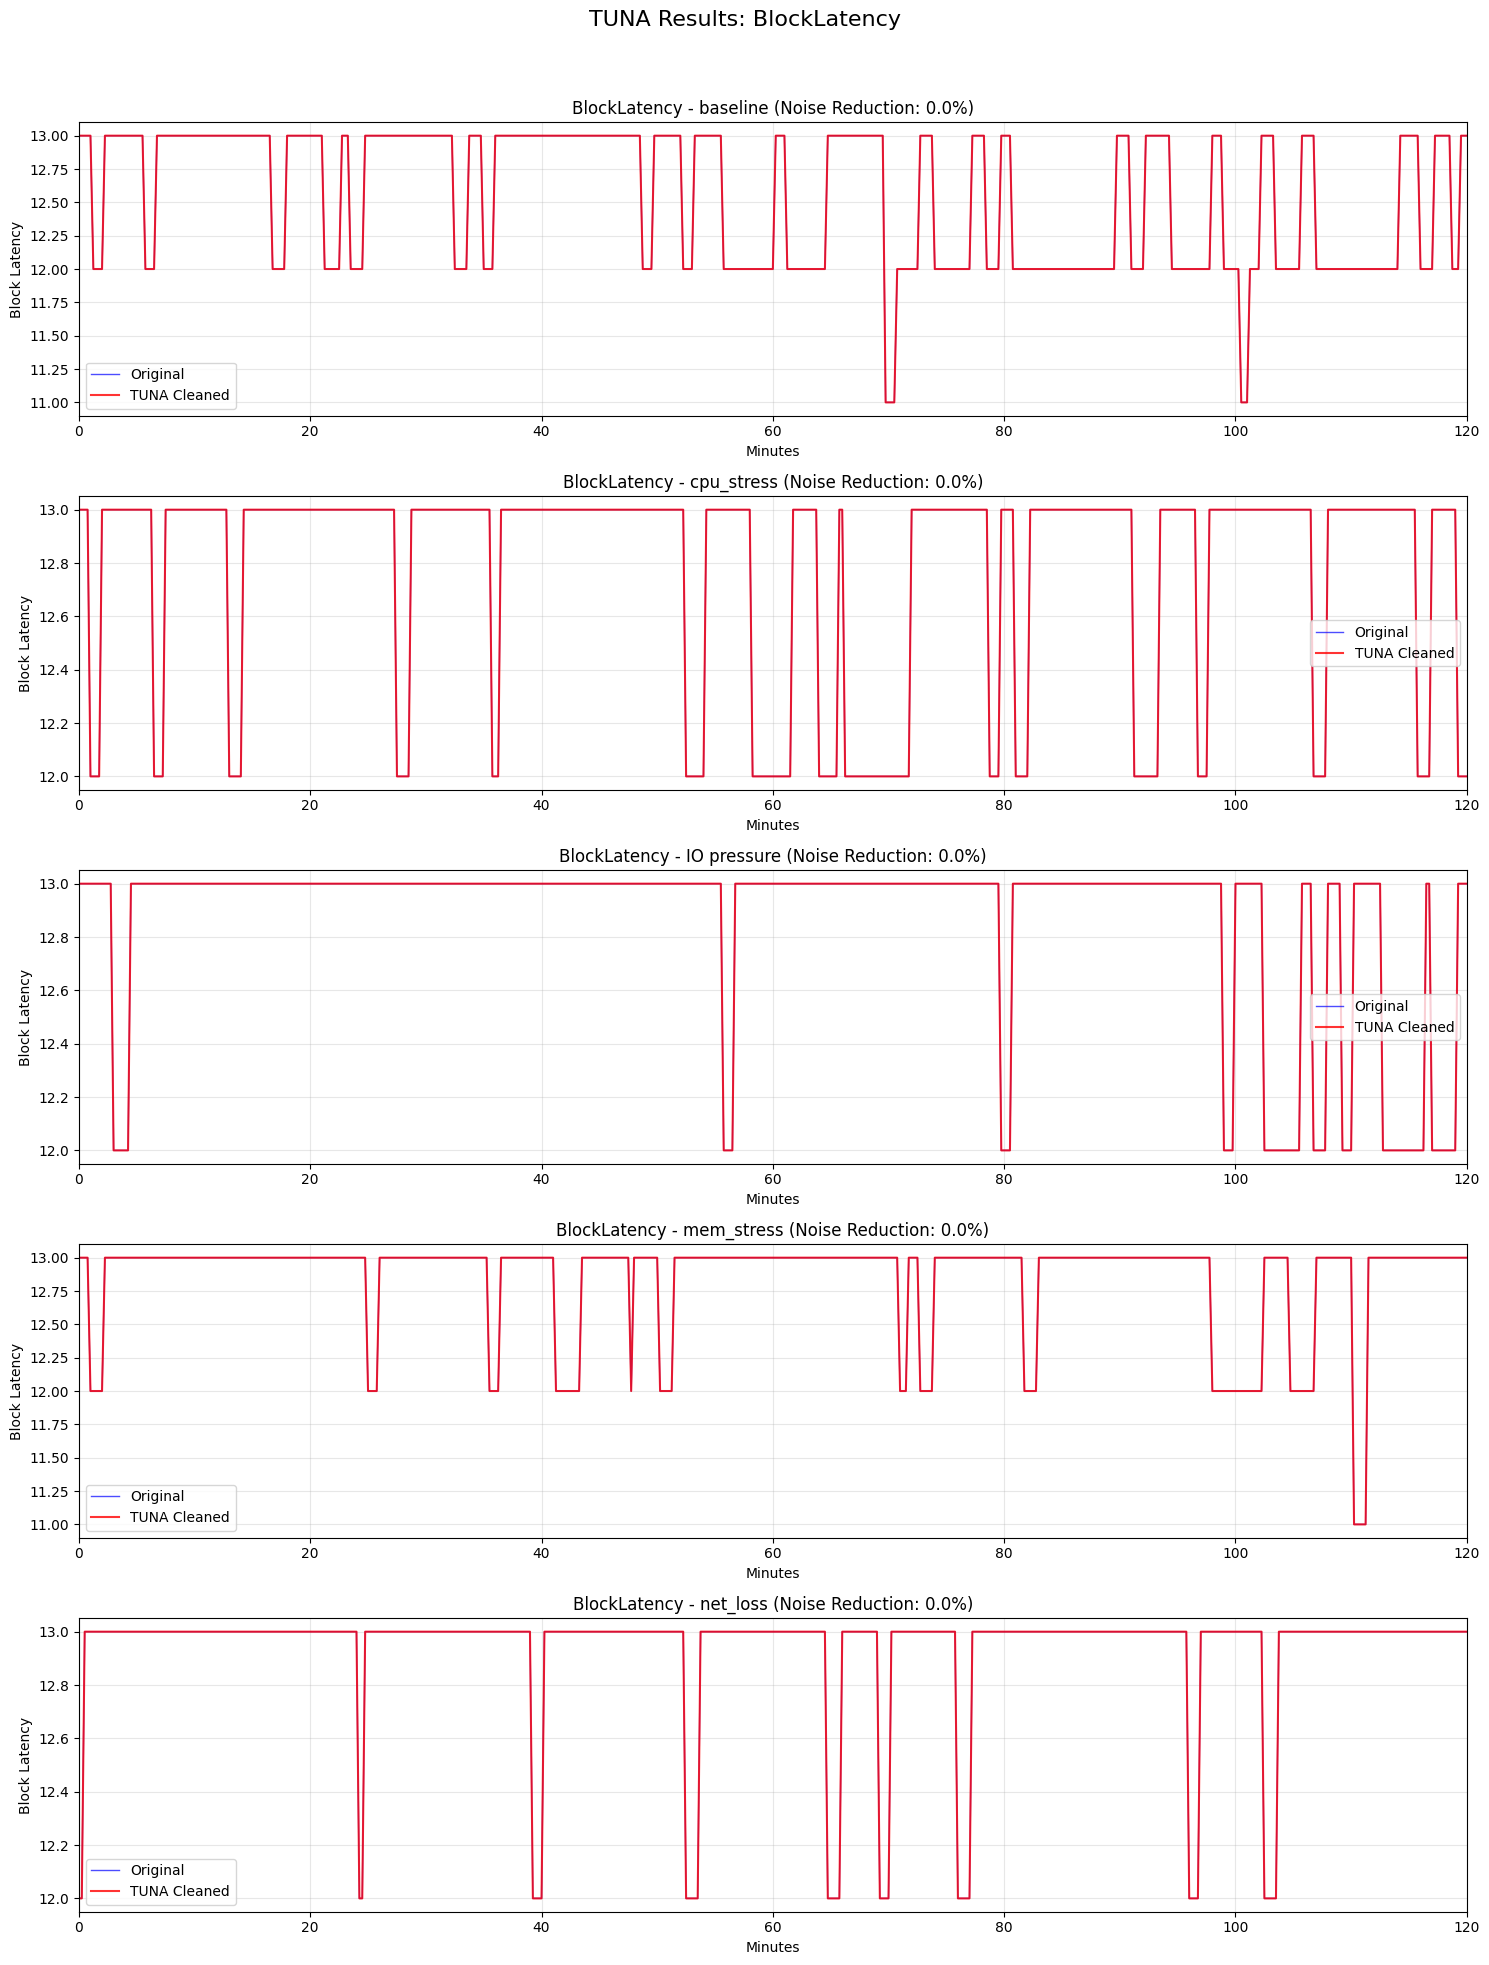

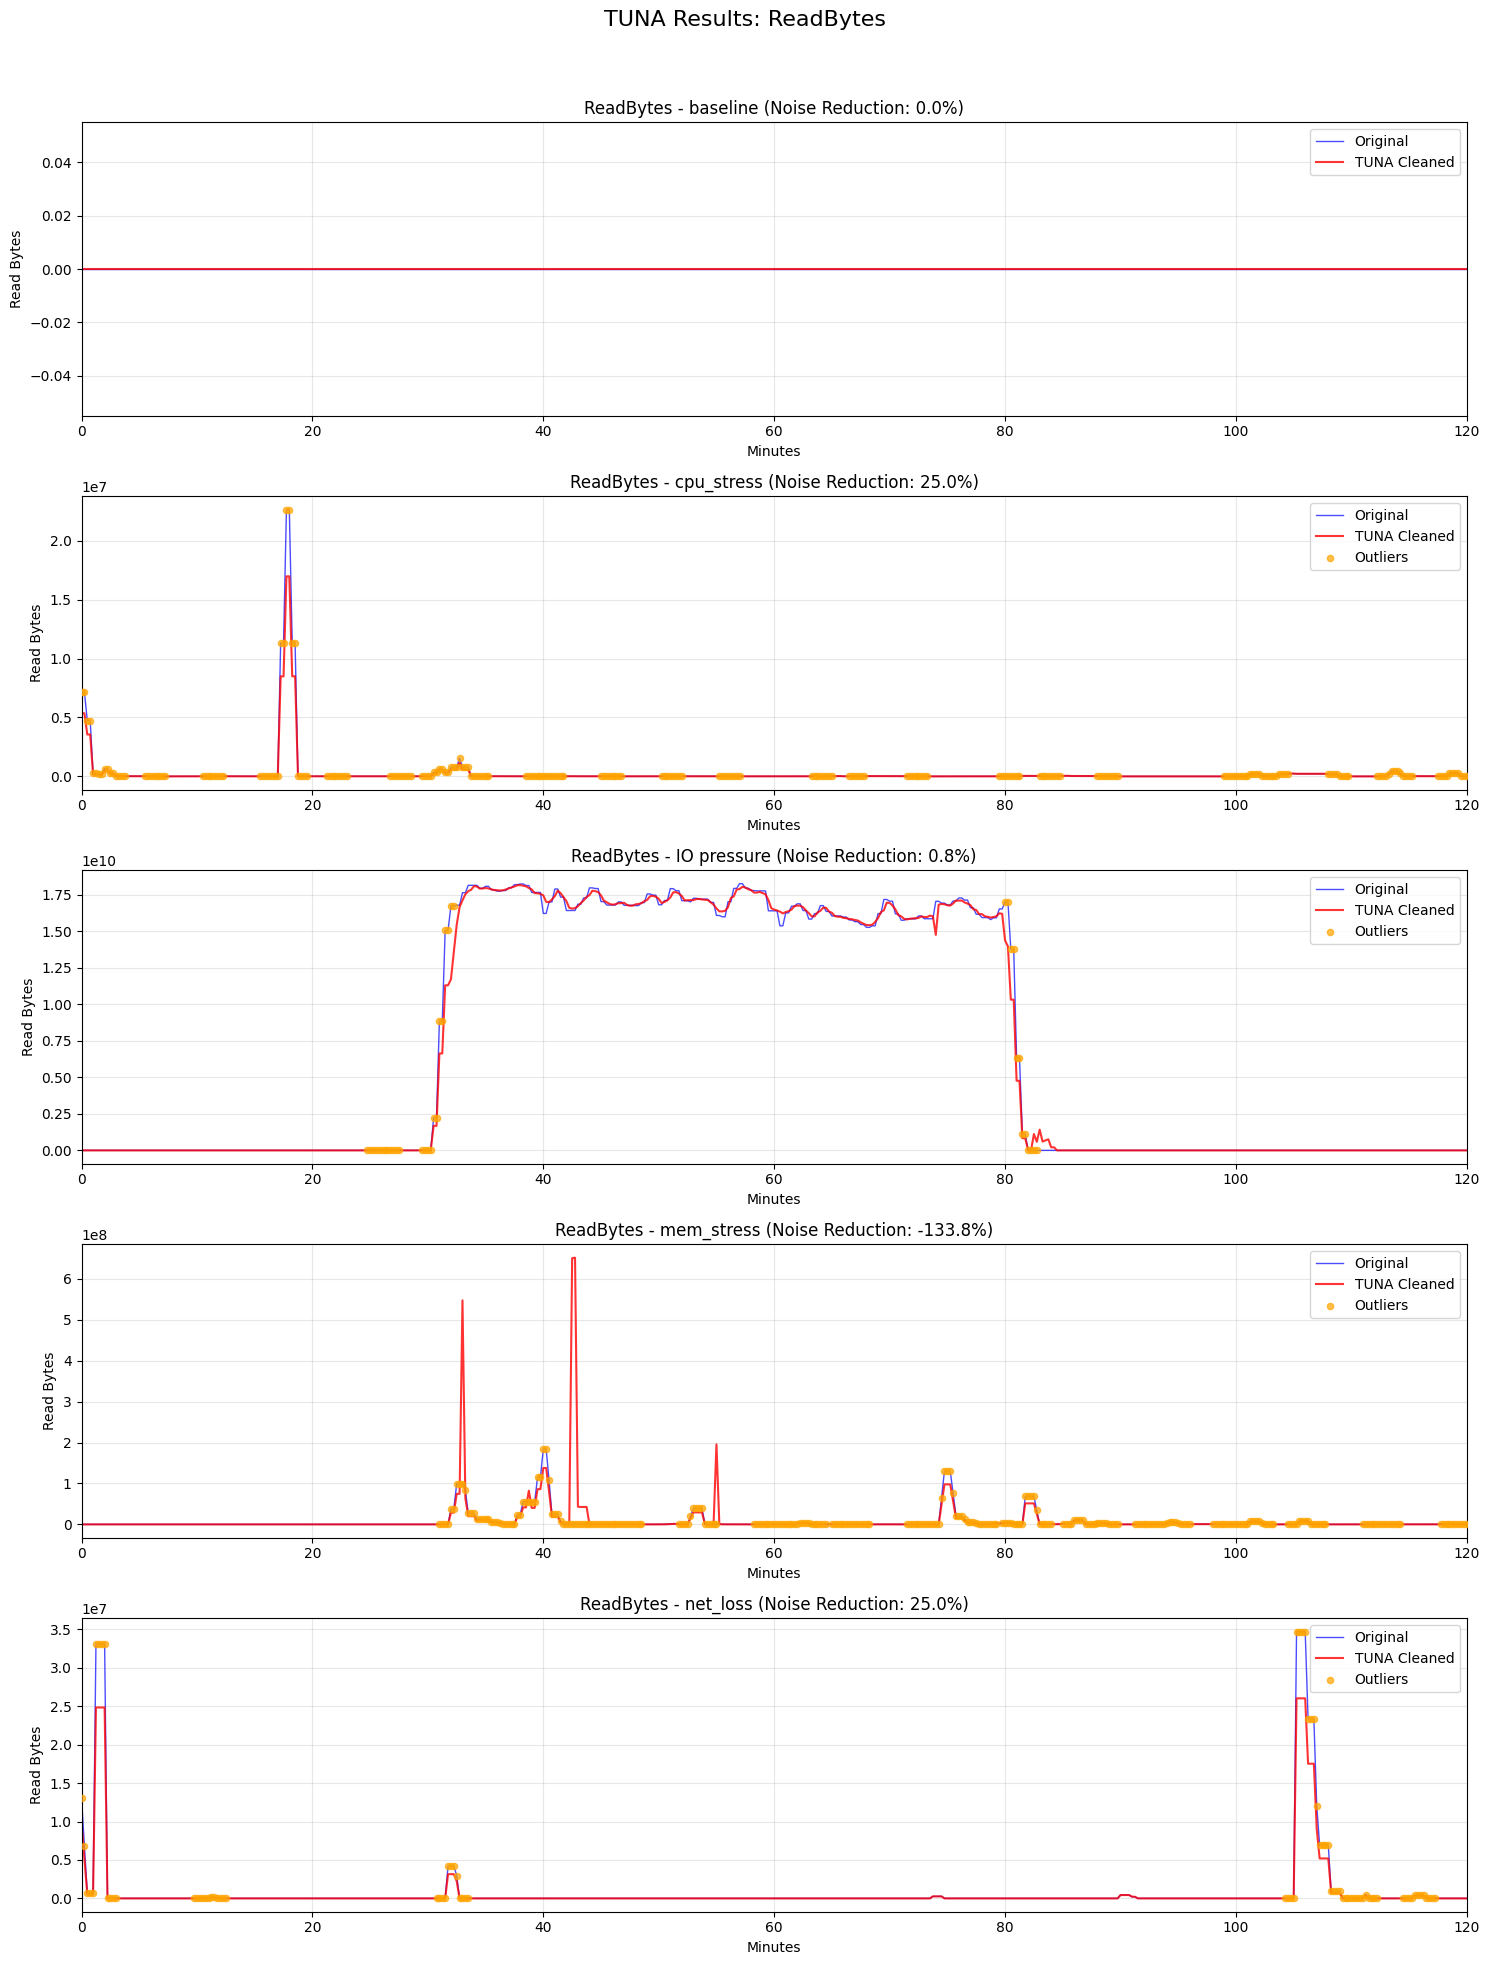

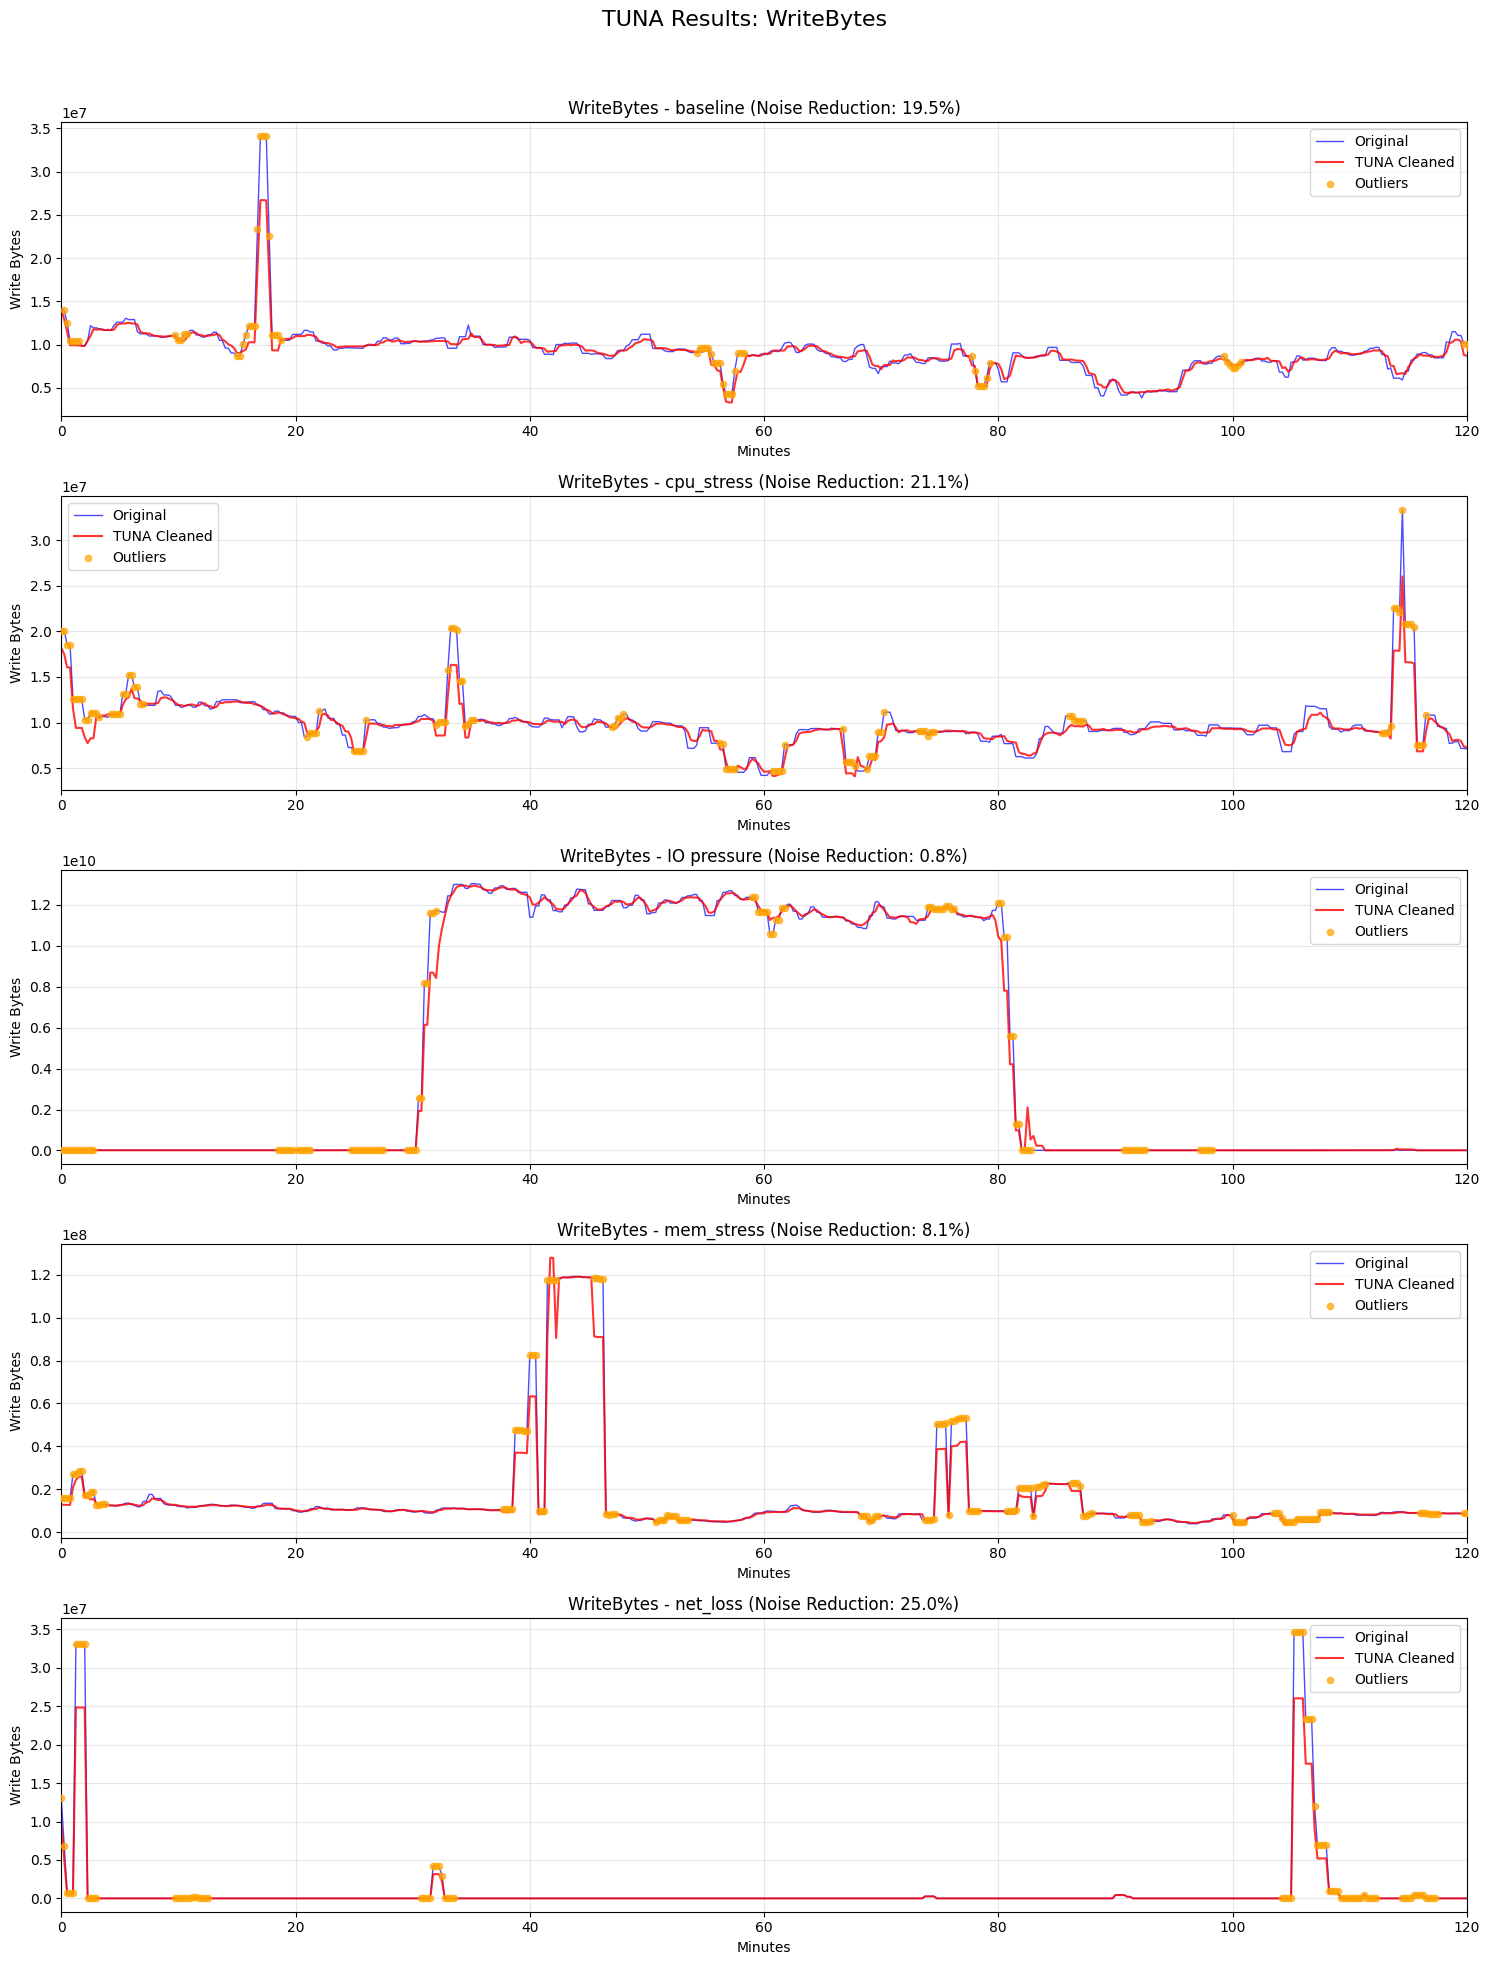


Disk I/O TUNA Results Summary:
Metric          Experiment   Outliers   Noise Red%   Correlation 
--------------------------------------------------------------------------------
BlockLatency    baseline     0                 0.0%       1.000
BlockLatency    cpu_stress   0                 0.0%       1.000
BlockLatency    IO pressure  0                 0.0%       1.000
BlockLatency    mem_stress   0                 0.0%       1.000
BlockLatency    net_loss     0                 0.0%       1.000
ReadBytes       baseline     0                 0.0%       1.000
ReadBytes       cpu_stress   349              25.0%       1.000
ReadBytes       IO pressure  52                0.8%       0.998
ReadBytes       mem_stress   535            -133.8%       0.387
ReadBytes       net_loss     138              25.0%       1.000
WriteBytes      baseline     83               19.5%       0.970
WriteBytes      cpu_stress   148              21.1%       0.957
WriteBytes      IO pressure  114               0.8%  

In [7]:
def safe_convert_to_float(series):
    try:
        return pd.to_numeric(series, errors='coerce').fillna(0.0).astype(float)
    except:
        return series.fillna(0.0).astype(float)

def safe_array_conversion(data):
    data = np.array(data, dtype=float)
    if np.any(np.isnan(data)):
        median_val = np.nanmedian(data)
        if np.isnan(median_val):
            median_val = 0.0
        data = np.nan_to_num(data, nan=median_val)
    return data

def detect_outliers_tuna(timeseries, window_size=5, threshold=0.65, min_absolute_range=None):
    timeseries = safe_array_conversion(timeseries)
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    if min_absolute_range is None:
        std_val = np.std(timeseries)
        if std_val == 0 or np.isnan(std_val):
            min_absolute_range = 0.01 * np.max(timeseries)
        else:
            min_absolute_range = 0.1 * std_val
    
    if min_absolute_range <= 0:
        min_absolute_range = 1e-6
    
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0 and window_range > 0:
            relative_range = window_range / window_mean
            
            if relative_range > threshold and window_range > min_absolute_range:
                for j in range(window_size):
                    actual_idx = i + j
                    outlier_mask[actual_idx] = True
    
    return outlier_mask

def create_features_for_ml(timeseries, experiment_type, window_size=10):
    timeseries = safe_array_conversion(timeseries)
    features = []
    
    for i in range(window_size, len(timeseries)):
        window = timeseries[i-window_size:i]
        
        feature_vector = [
            np.mean(window),
            np.std(window),
            np.median(window),
            np.max(window) - np.min(window),
            timeseries[i-1],
            i / len(timeseries),
        ]
        
        feature_vector = [0.0 if np.isnan(val) or np.isinf(val) else float(val) for val in feature_vector]
        
        exp_features = [0, 0, 0, 0, 0]
        if experiment_type == "baseline":
            exp_features[0] = 1
        elif experiment_type == "cpu_stress":
            exp_features[1] = 1
        elif experiment_type == "delay":
            exp_features[2] = 1
        elif experiment_type == "mem_stress":
            exp_features[3] = 1
        elif experiment_type == "net_loss":
            exp_features[4] = 1
        
        feature_vector.extend(exp_features)
        features.append(feature_vector)
    
    return np.array(features)

def apply_penalty(timeseries, outlier_mask, penalty_factor=0.75):
    timeseries = safe_array_conversion(timeseries)
    cleaned_series = timeseries.copy()
    
    outlier_indices = np.where(outlier_mask)[0]
    for i in outlier_indices:
        original_value = timeseries[i]
        if original_value != 0:
            cleaned_series[i] = original_value * penalty_factor
    
    return cleaned_series

def apply_tuna_to_single_series(values, exp_name, model, scaler, penalty_factor=0.75, blend_weight=1.0, metric_name=""):
    values = safe_array_conversion(values)
    
    unique_values = len(np.unique(values))
    data_range = np.max(values) - np.min(values)
    zero_percentage = np.sum(values == 0) / len(values) * 100
    
    is_discrete_data = (
        unique_values <= 10 and data_range <= 50
        or zero_percentage > 60
        or (unique_values <= 20 and all(x == int(x) for x in np.unique(values) if not np.isnan(x)))
    )
    
    outlier_mask = detect_outliers_tuna(values, window_size=5, threshold=0.65)
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    cleaned_series = apply_penalty(values, outlier_mask, penalty_factor)
    
    if not is_discrete_data and model is not None and scaler is not None:
        try:
            features = create_features_for_ml(values, exp_name)
            if len(features) > 0:
                features_scaled = scaler.transform(features)
                ml_predictions = model.predict(features_scaled)
                
                for i, prediction in enumerate(ml_predictions):
                    actual_idx = i + 10
                    if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                        if not np.isnan(prediction) and not np.isinf(prediction):
                            cleaned_series[actual_idx] = prediction
                
                cleaned_series = np.maximum(0, cleaned_series)
        except Exception:
            pass
    
    original_std = np.std(values)
    cleaned_std = np.std(cleaned_series)
    
    if original_std > 0 and not np.isnan(original_std):
        noise_reduction = (original_std - cleaned_std) / original_std * 100
    else:
        noise_reduction = 0.0
    
    if len(values) > 1:
        correlation = np.corrcoef(values, cleaned_series)[0, 1]
        if np.isnan(correlation):
            correlation = 1.0
    else:
        correlation = 1.0
    
    cleaning_stats = {
        'outliers': outliers_count,
        'noise_reduction': noise_reduction,
        'correlation': correlation
    }
    
    return cleaned_series, outlier_mask, cleaning_stats

def apply_tuna_to_each_disk_column(df, exp_name, models, scalers, penalty_factor=0.75, blend_weight=1.0, metric_name=""):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    column_results = {}
    cleaned_df = df.copy()
    
    for col in value_cols:
        col_values = safe_convert_to_float(df[col])
        model = models.get(col)
        scaler = scalers.get(col)
        
        cleaned_values, outlier_mask, stats = apply_tuna_to_single_series(
            col_values, exp_name, model, scaler, penalty_factor, blend_weight, f"{metric_name}_{col}"
        )
        
        column_results[col] = {
            'original': col_values,
            'cleaned': cleaned_values,
            'outliers': outlier_mask,
            'stats': stats
        }
        
        cleaned_df[col] = cleaned_values
    
    return cleaned_df, column_results

def train_models_for_all_disk_columns(metric_name, all_experiments):
    exclude_cols = ['Time', 'Minutes', 'source']
    
    first_df = list(all_experiments.values())[0]
    value_cols = [col for col in first_df.columns if col not in exclude_cols]
    
    models = {}
    scalers = {}
    
    for col in value_cols:
        X_stable_all = []
        y_stable_all = []
        
        for exp_name, df in all_experiments.items():
            col_values = safe_convert_to_float(df[col])
            col_values = safe_array_conversion(col_values)
            
            outlier_mask = detect_outliers_tuna(col_values)
            stable_mask = ~outlier_mask
            
            features = create_features_for_ml(col_values, exp_name)
            if len(features) > 0:
                stable_features_mask = stable_mask[10:10+len(features)]
                stable_features = features[stable_features_mask]
                stable_targets = col_values[10:10+len(features)][stable_features_mask]
                
                valid_mask = ~(np.isnan(stable_targets) | np.isinf(stable_targets))
                stable_features = stable_features[valid_mask]
                stable_targets = stable_targets[valid_mask]
                
                if len(stable_features) > 0:
                    smoothed_targets = []
                    for j, target in enumerate(stable_targets):
                        start_idx = max(0, j-2)
                        end_idx = min(len(stable_targets), j+3)
                        local_values = stable_targets[start_idx:end_idx]
                        smoothed_targets.append(np.median(local_values))
                    
                    X_stable_all.extend(stable_features)
                    y_stable_all.extend(smoothed_targets)
        
        if len(X_stable_all) >= 10:
            X_stable_all = np.array(X_stable_all)
            y_stable_all = np.array(y_stable_all)
            
            nan_mask = np.isnan(y_stable_all) | np.isinf(y_stable_all)
            if np.any(nan_mask):
                X_stable_all = X_stable_all[~nan_mask]
                y_stable_all = y_stable_all[~nan_mask]
            
            feature_nan_mask = np.isnan(X_stable_all).any(axis=1) | np.isinf(X_stable_all).any(axis=1)
            if np.any(feature_nan_mask):
                X_stable_all = X_stable_all[~feature_nan_mask]
                y_stable_all = y_stable_all[~feature_nan_mask]
            
            if len(X_stable_all) >= 10:
                try:
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X_stable_all)
                    
                    model = RandomForestRegressor(
                        n_estimators=50,
                        max_depth=10,
                        min_samples_split=5,
                        min_samples_leaf=2,
                        max_features='sqrt',
                        random_state=42,
                        n_jobs=1
                    )
                    
                    model.fit(X_scaled, y_stable_all)
                    
                    models[col] = model
                    scalers[col] = scaler
                except Exception:
                    models[col] = None
                    scalers[col] = None
            else:
                models[col] = None
                scalers[col] = None
        else:
            models[col] = None
            scalers[col] = None
    
    return models, scalers

def run_tuna_for_all_disk_metrics_by_column(all_datasets):
    tuna_results = {}
    
    for metric_name, experiments in all_datasets.items():
        models, scalers = train_models_for_all_disk_columns(metric_name, experiments)
        
        metric_results = {}
        for exp_name, df in experiments.items():
            cleaned_df, column_results = apply_tuna_to_each_disk_column(
                df, exp_name, models, scalers, metric_name=metric_name
            )
            
            # Calculate overall statistics for compatibility
            exclude_cols = ['Time', 'Minutes', 'source']
            value_cols = [col for col in df.columns if col not in exclude_cols]
            
            if len(value_cols) == 1:
                original_values = safe_convert_to_float(df[value_cols[0]])
                cleaned_values = cleaned_df[value_cols[0]].values
            else:
                original_values = df[value_cols].sum(axis=1).values
                cleaned_values = cleaned_df[value_cols].sum(axis=1).values
            
            original_std = np.nanstd(original_values)
            cleaned_std = np.nanstd(cleaned_values)
            
            if original_std > 0 and not np.isnan(original_std):
                noise_reduction = (original_std - cleaned_std) / original_std * 100
            else:
                noise_reduction = 0.0
            
            if len(original_values) > 1:
                correlation = np.corrcoef(original_values, cleaned_values)[0, 1]
                if np.isnan(correlation):
                    correlation = 1.0
            else:
                correlation = 1.0
            
            total_outliers = sum(result['stats']['outliers'] for result in column_results.values())
            
            overall_outlier_mask = np.zeros(len(df), dtype=bool)
            for col_result in column_results.values():
                overall_outlier_mask |= col_result['outliers']
            
            metric_results[exp_name] = {
                'original': original_values,
                'cleaned': cleaned_values,
                'outliers': overall_outlier_mask,
                'stats': {
                    'outliers': total_outliers,
                    'noise_reduction': noise_reduction,
                    'correlation': correlation
                },
                'column_results': column_results,
                'cleaned_df': cleaned_df
            }
        
        tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results(tuna_results, all_datasets):
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            outlier_points = np.where(outliers)[0]
            if len(outlier_points) > 0:
                axes[i].scatter(minutes[outlier_points], original[outlier_points], 
                               c='orange', s=20, alpha=0.7, label='Outliers', zorder=5)
            
            if 'block' in metric_name.lower() or 'latency' in metric_name.lower():
                y_label = 'Block Latency'
            elif 'read' in metric_name.lower():
                y_label = 'Read Bytes'
            elif 'write' in metric_name.lower():
                y_label = 'Write Bytes'
            else:
                y_label = 'Disk Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%)')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_tuna_summary(tuna_results):
    print("\nDisk I/O TUNA Results Summary:")
    print("="*80)
    print(f"{'Metric':<15} {'Experiment':<12} {'Outliers':<10} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*80)
    
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            print(f"{metric_name:<15} {exp_name:<12} {stats['outliers']:<10} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

def create_cleaned_csv_from_tuna_disk_columns(original_df, column_results, metric_name, experiment_name, include_metadata=False):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in original_df.columns if col not in exclude_cols]
    
    cleaned_df = original_df.copy()
    
    total_outliers = 0
    
    for col in value_cols:
        if col in column_results:
            cleaned_values = column_results[col]['cleaned']
            cleaned_df[col] = cleaned_values[:len(cleaned_df)]
            total_outliers += column_results[col]['stats']['outliers']
    
    if include_metadata:
        cleaned_df['tuna_processed'] = True
        cleaned_df['tuna_total_outliers'] = total_outliers
        cleaned_df['tuna_metric_name'] = metric_name
        cleaned_df['tuna_experiment'] = experiment_name
        
        for col in value_cols:
            if col in column_results:
                outlier_mask = column_results[col]['outliers']
                stats = column_results[col]['stats']
                cleaned_df[f'tuna_outlier_{col}'] = outlier_mask[:len(cleaned_df)]
                cleaned_df[f'tuna_noise_reduction_{col}'] = stats['noise_reduction']
                cleaned_df[f'tuna_correlation_{col}'] = stats['correlation']
    
    return cleaned_df

def export_all_cleaned_csvs(tuna_results, all_datasets, output_base_path="cleaned_disk_data", include_metadata=False, preserve_structure=True):
    """Export all TUNA-cleaned datasets organized by experiment type"""
    output_base = Path(output_base_path)
    output_base.mkdir(parents=True, exist_ok=True)
    
    created_files = {}
    total_files = 0
    
    # Get all experiment types
    experiment_types = set()
    for metric_results in tuna_results.values():
        experiment_types.update(metric_results.keys())
    
    print(f"📁 Creating directories for experiments: {sorted(experiment_types)}")
    
    # Create directory structure by experiment type
    for exp_name in experiment_types:
        exp_dir = output_base / exp_name
        exp_dir.mkdir(exist_ok=True)
        created_files[exp_name] = []
    
    # Process each metric and experiment
    for metric_name, metric_results in tuna_results.items():
        print(f"\n📊 Processing {metric_name}...")
        
        for exp_name, results in metric_results.items():
            print(f"  🔄 Exporting {exp_name}...")
            
            # Get original dataframe
            original_df = all_datasets[metric_name][exp_name]
            
            # Create cleaned dataframe
            if 'column_results' in results:
                column_results = results['column_results']
                cleaned_df = create_cleaned_csv_from_tuna_disk_columns(
                    original_df=original_df,
                    column_results=column_results,
                    metric_name=metric_name,
                    experiment_name=exp_name,
                    include_metadata=include_metadata
                )
                
                # Print detailed column statistics
                for col, col_result in column_results.items():
                    col_stats = col_result['stats']
                    print(f"    📈 {col}: {col_stats['outliers']} outliers, {col_stats['noise_reduction']:.1f}% noise reduction")
                
                total_outliers = sum(col_result['stats']['outliers'] for col_result in column_results.values())
                overall_stats = results['stats']
            else:
                cleaned_df = original_df.copy()
                total_outliers = results['stats']['outliers']
                overall_stats = results['stats']
            
            # Create filename: metric_experiment.csv
            csv_filename = f"{metric_name.lower()}_{exp_name}.csv"
            csv_path = output_base / exp_name / csv_filename
            
            # Export to CSV
            cleaned_df.to_csv(csv_path, index=False)
            created_files[exp_name].append(str(csv_path))
            total_files += 1
            
            # Print summary
            outliers_pct = (total_outliers / len(cleaned_df)) * 100
            print(f"    ✅ {csv_filename}")
            print(f"       📈 Total outliers: {total_outliers} ({outliers_pct:.1f}%)")
            print(f"       🔧 Overall noise reduction: {overall_stats['noise_reduction']:.1f}%")
            print(f"       📊 Overall correlation: {overall_stats['correlation']:.3f}")
    
    print(f"\n✅ Export completed!")
    print(f"📁 Total files created: {total_files}")
    print(f"📂 Directory structure:")
    for exp_name in sorted(experiment_types):
        print(f"  {exp_name}/")
        for file_path in created_files[exp_name]:
            print(f"    📄 {Path(file_path).name}")
    
    return created_files

def main(all_datasets):
    tuna_results = run_tuna_for_all_disk_metrics_by_column(all_datasets)
    plot_tuna_results(tuna_results, all_datasets)
    print_tuna_summary(tuna_results)
    
    created_files = export_all_cleaned_csvs(
        tuna_results=tuna_results,
        all_datasets=all_datasets,
        output_base_path="cleaned_disk_data",
        include_metadata=False
    )
    
    return tuna_results

if __name__ == "__main__":
    tuna_results = main(all_datasets)


COMPREHENSIVE DISK I/O ANALYSIS
Each disk metric will be compared to its own baseline

🔍 Analyzing BlockLatency...

📊 Comparing BlockLatency: cpu_stress stress vs baseline


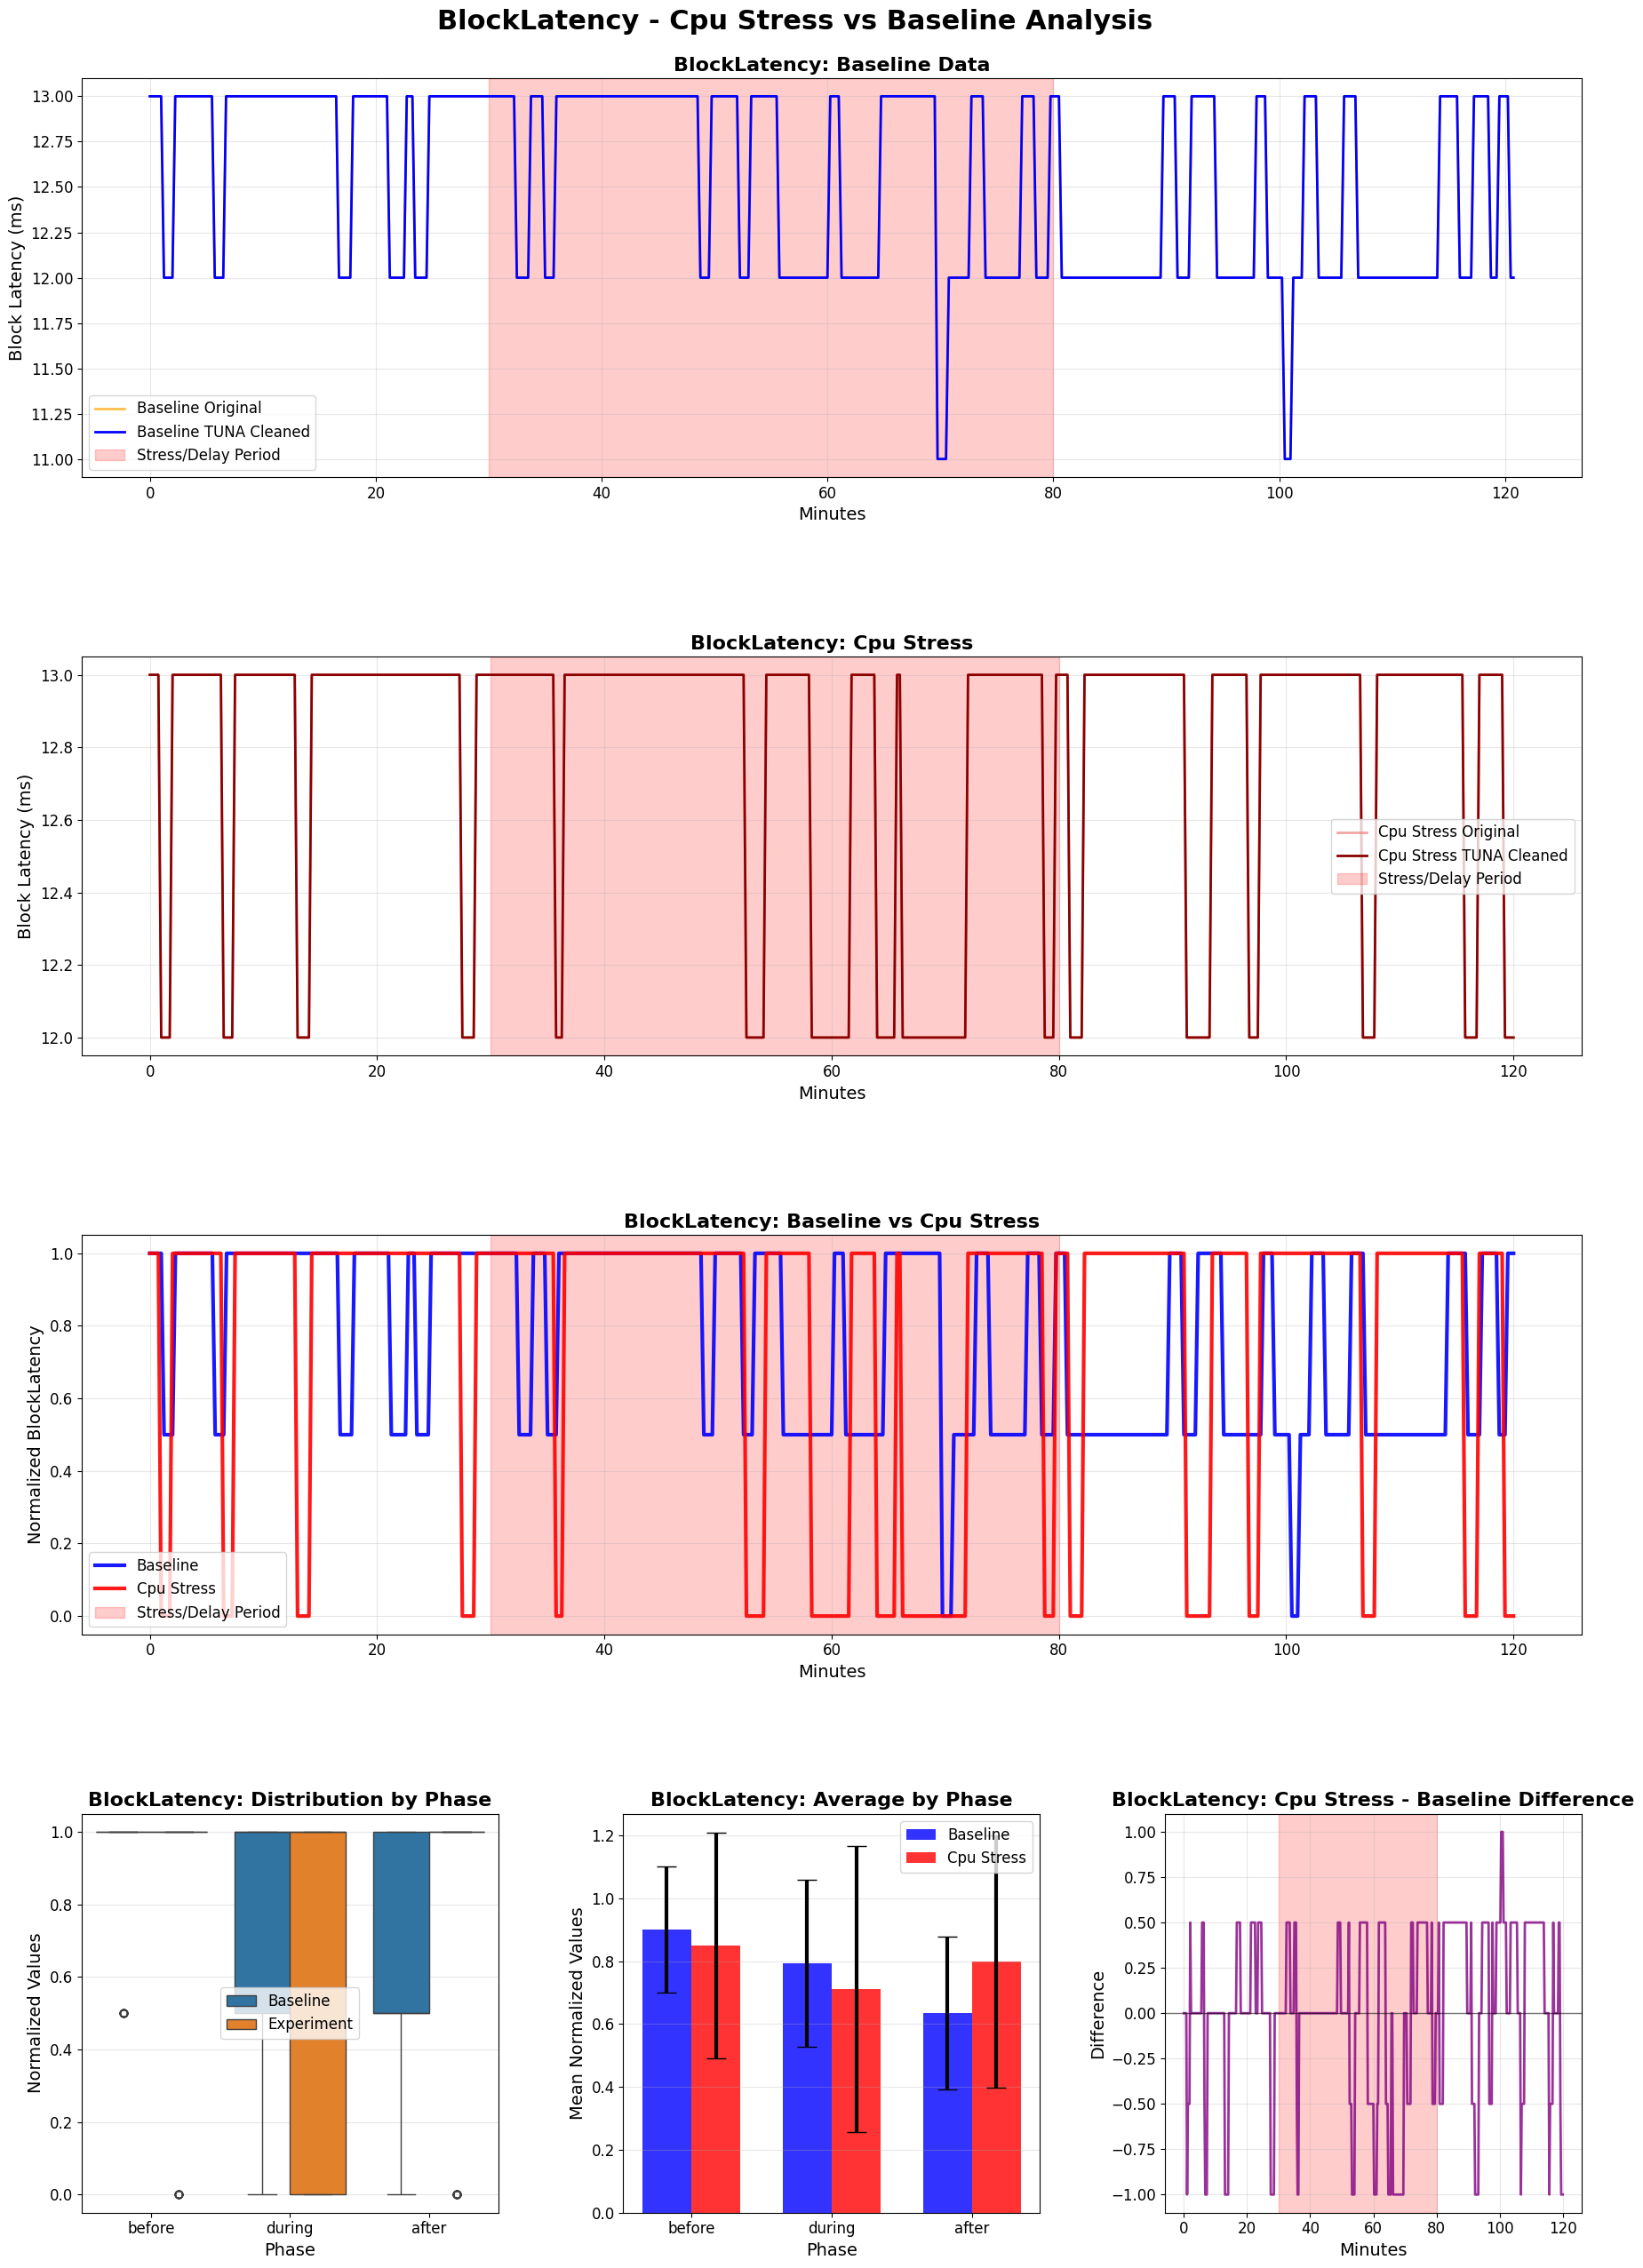


BLOCKLATENCY - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6344  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8000  0.4013  0.0  1.0
before  0.8500  0.3586  0.0  1.0
during  0.7114  0.4542  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  1.33, p=  0.1839 (NOT SIGNIFICANT)
  DURING  : t=  2.21, p=  0.0276 (SIGNIFICANT)
  AFTER   : t= -4.47, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   -5.56% (DECREASE)
  DURING  :  -10.34% (DECREASE)
  AFTER   :  +26.11% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)


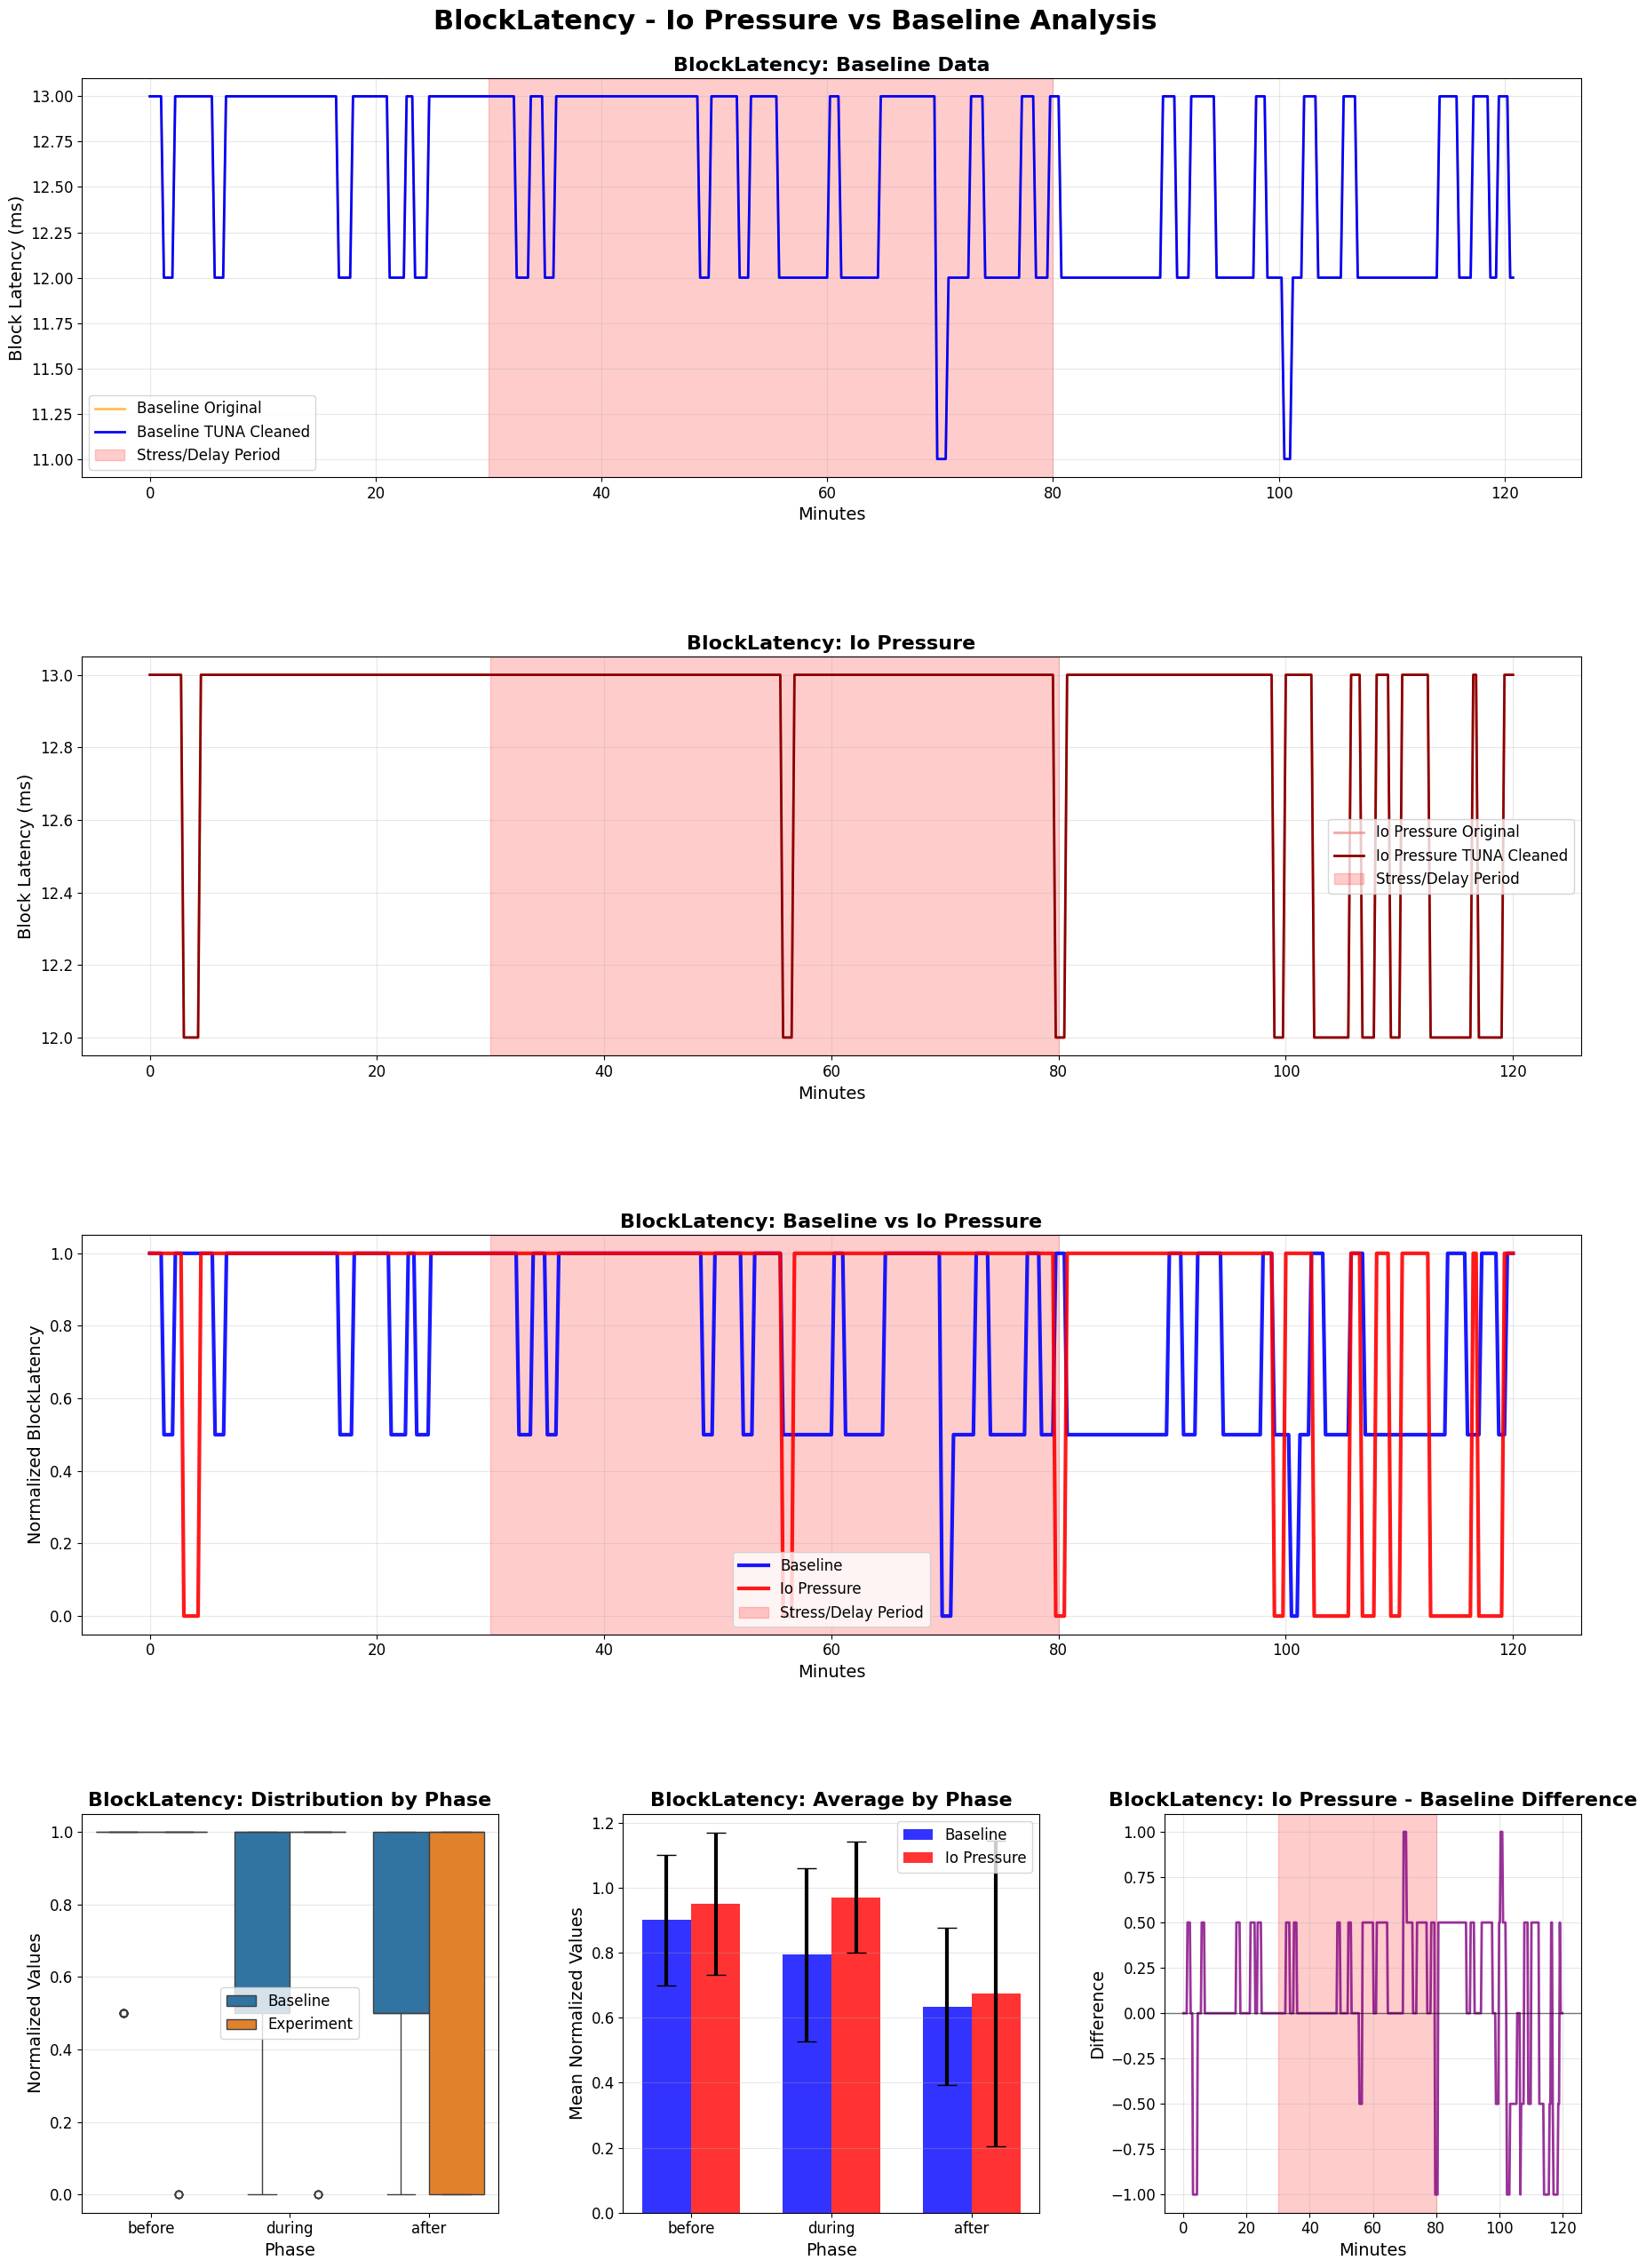


BLOCKLATENCY - IO PRESSURE VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  IO PRESSURE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6344  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

IO PRESSURE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6750  0.4698  0.0  1.0
before  0.9500  0.2189  0.0  1.0
during  0.9701  0.1706  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.84, p=  0.0664 (NOT SIGNIFICANT)
  DURING  : t= -7.92, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -0.97, p=  0.3319 (NOT SIGNIFICANT)

IO PRESSURE IMPACT:
  BEFORE  :   +5.56% (INCREASE)
  DURING  :  +22.26% (INCREASE)
  AFTER   :   +6.40% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Laten

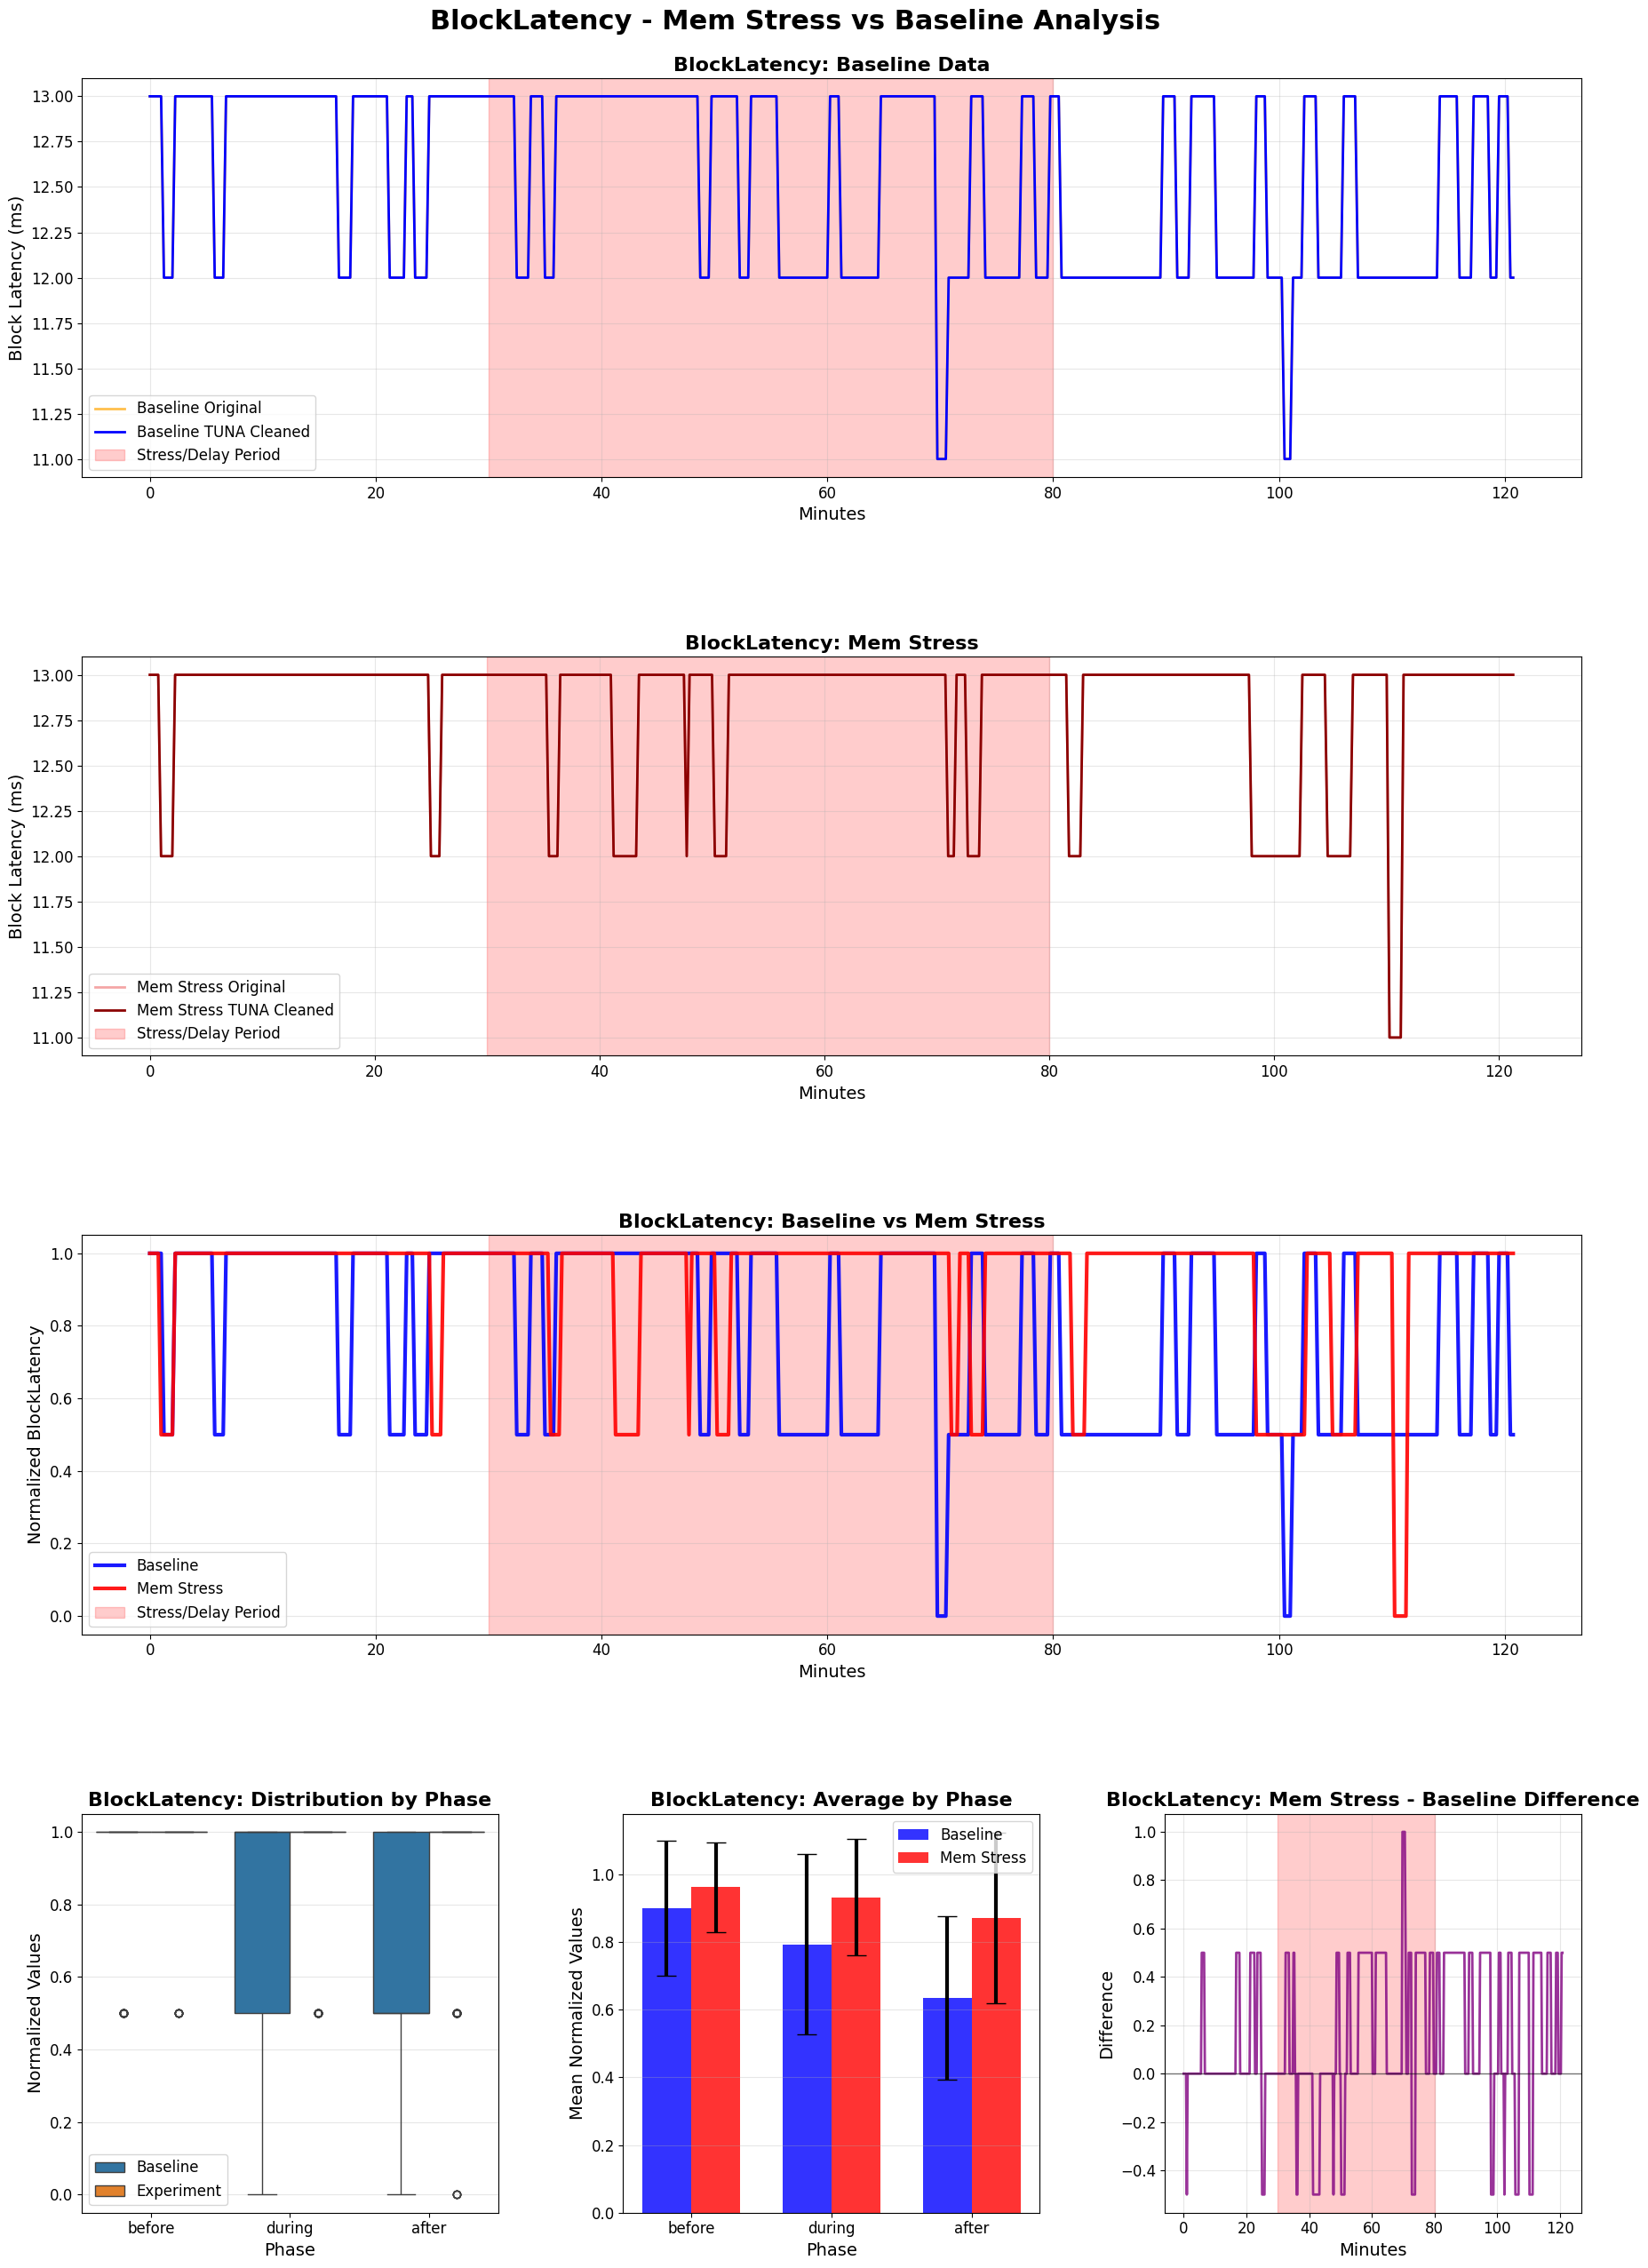


BLOCKLATENCY - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8712  0.2521  0.0  1.0
before  0.9625  0.1322  0.5  1.0
during  0.9328  0.1709  0.5  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.85, p=  0.0048 (SIGNIFICANT)
  DURING  : t= -6.24, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -8.62, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +6.94% (INCREASE)
  DURING  :  +17.55% (INCREASE)
  AFTER   :  +37.20% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Co

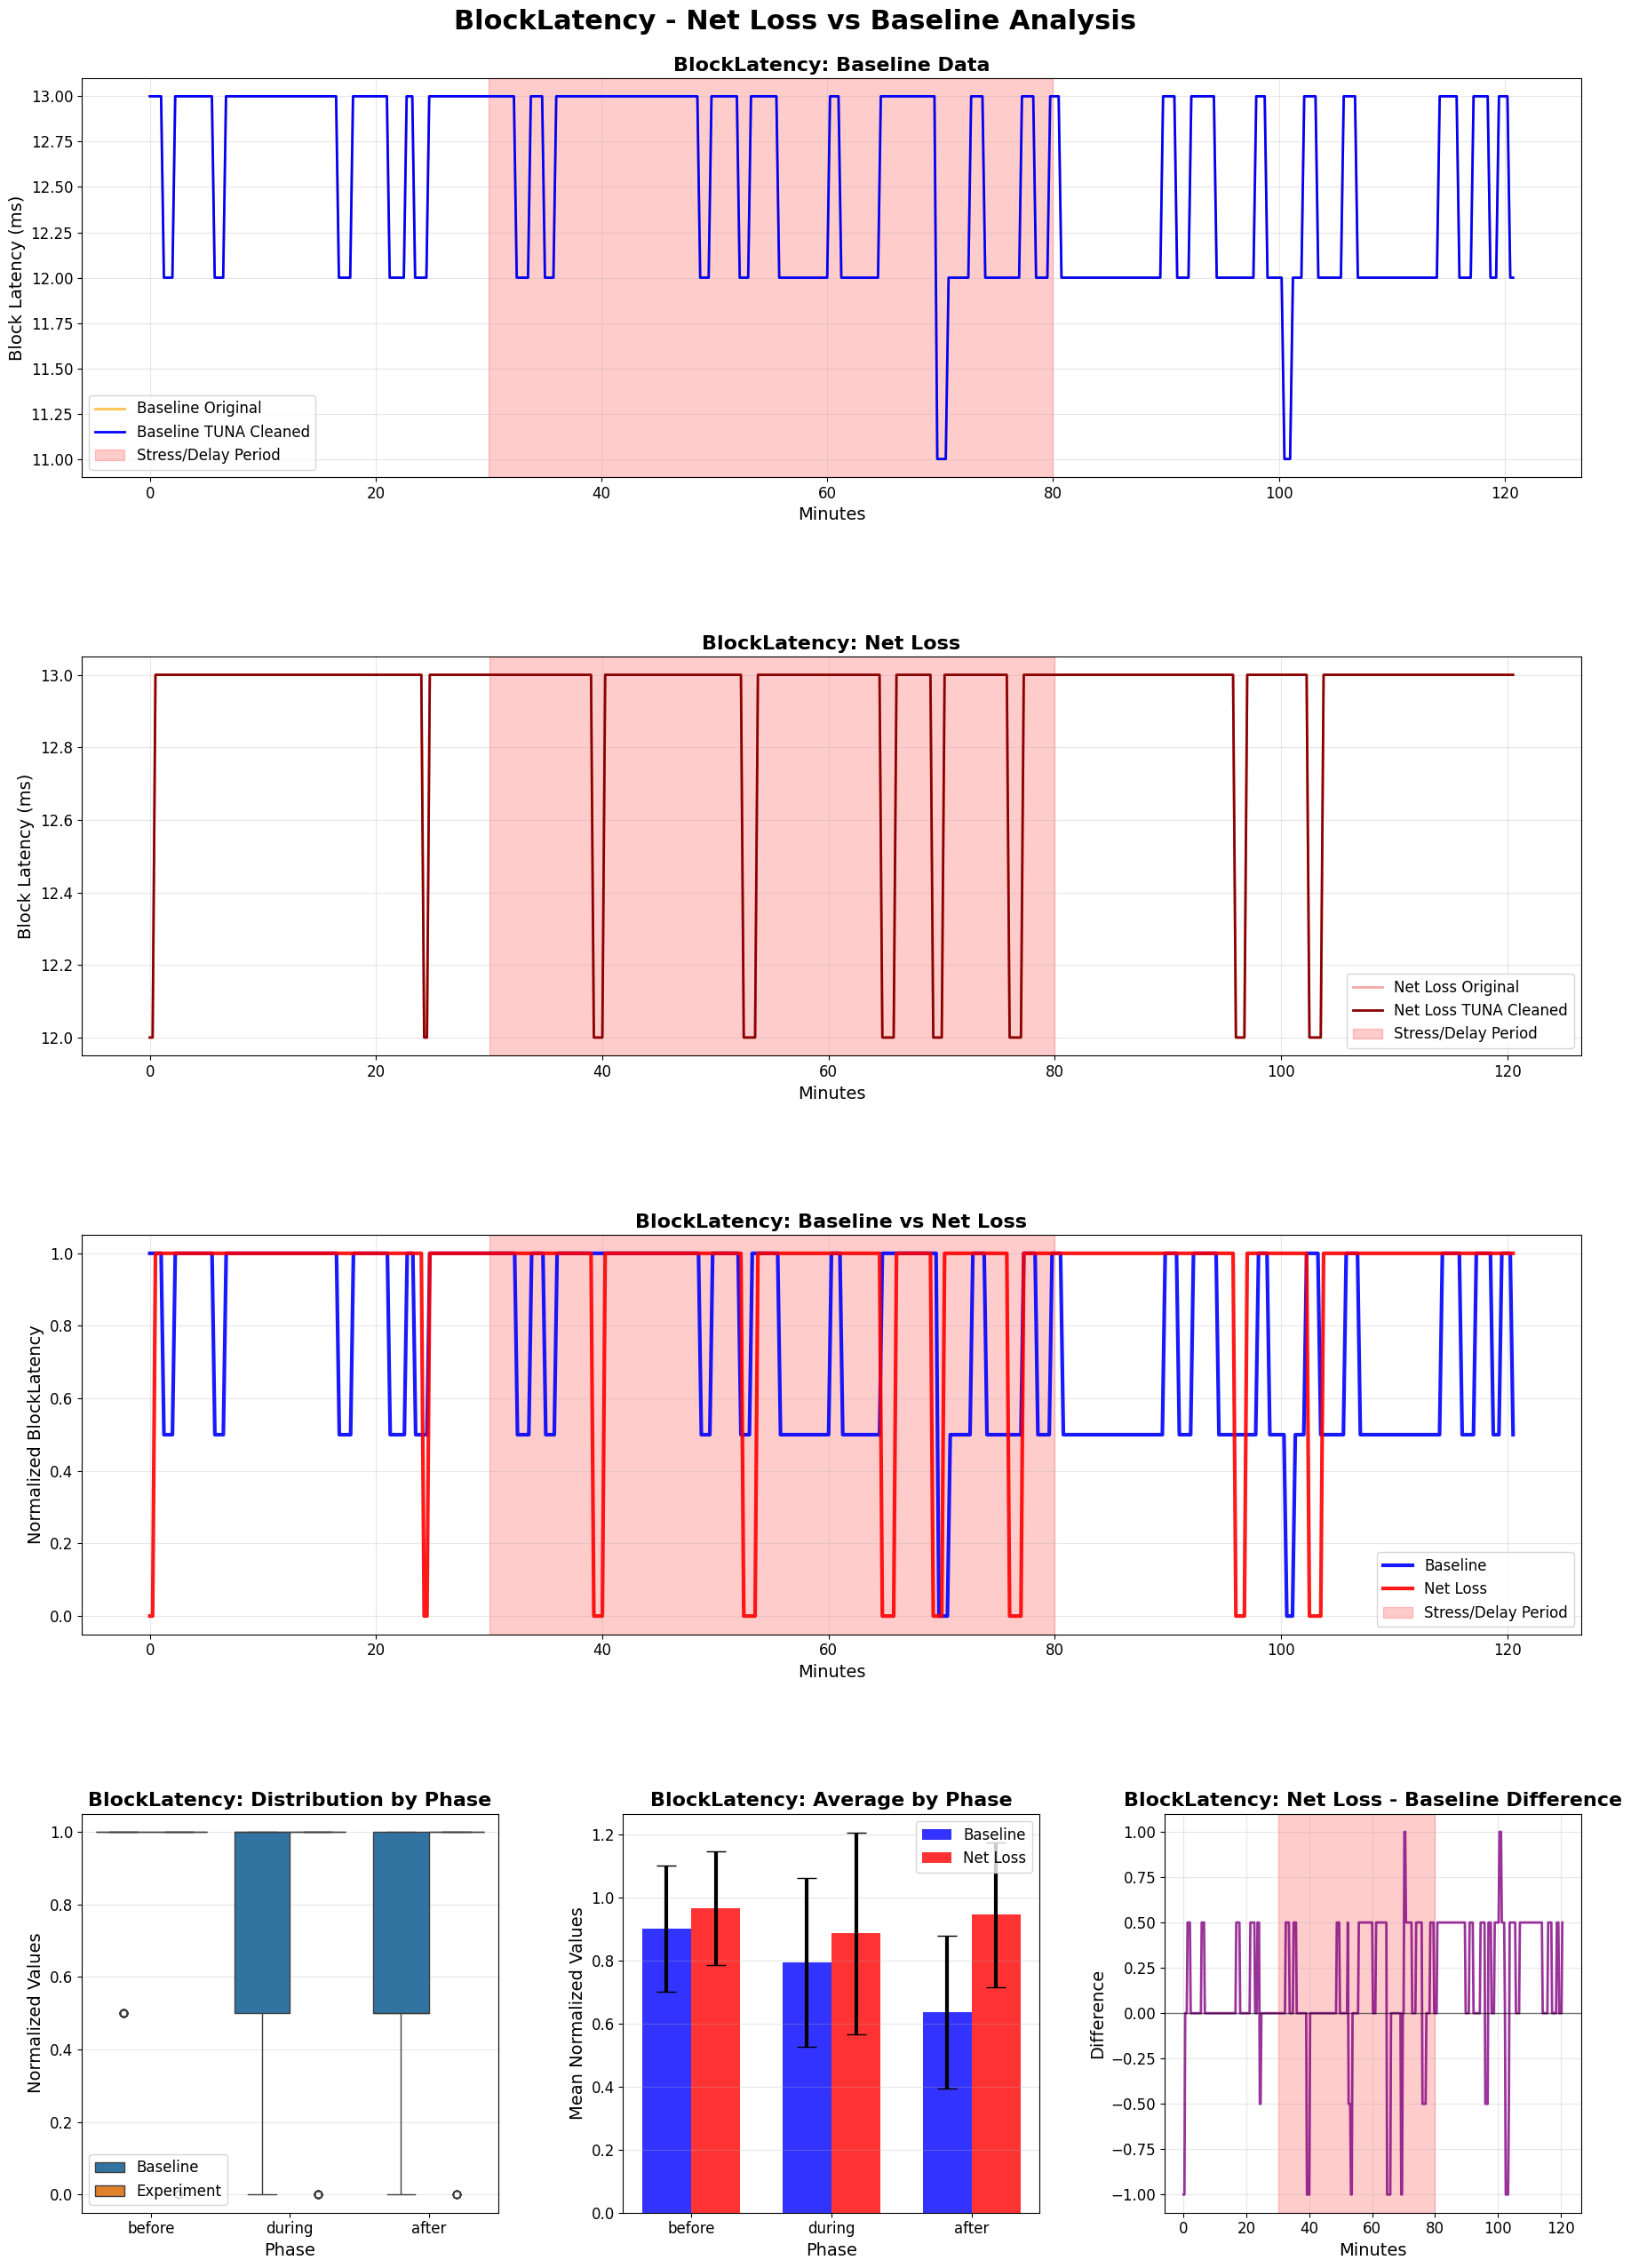


BLOCKLATENCY - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6358  0.2431  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.9444  0.2298  0.0  1.0
before  0.9667  0.1803  0.0  1.0
during  0.8856  0.3191  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.71, p=  0.0073 (SIGNIFICANT)
  DURING  : t= -3.14, p=  0.0018 (SIGNIFICANT)
  AFTER   : t=-11.74, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +7.41% (INCREASE)
  DURING  :  +11.60% (INCREASE)
  AFTER   :  +48.54% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns an

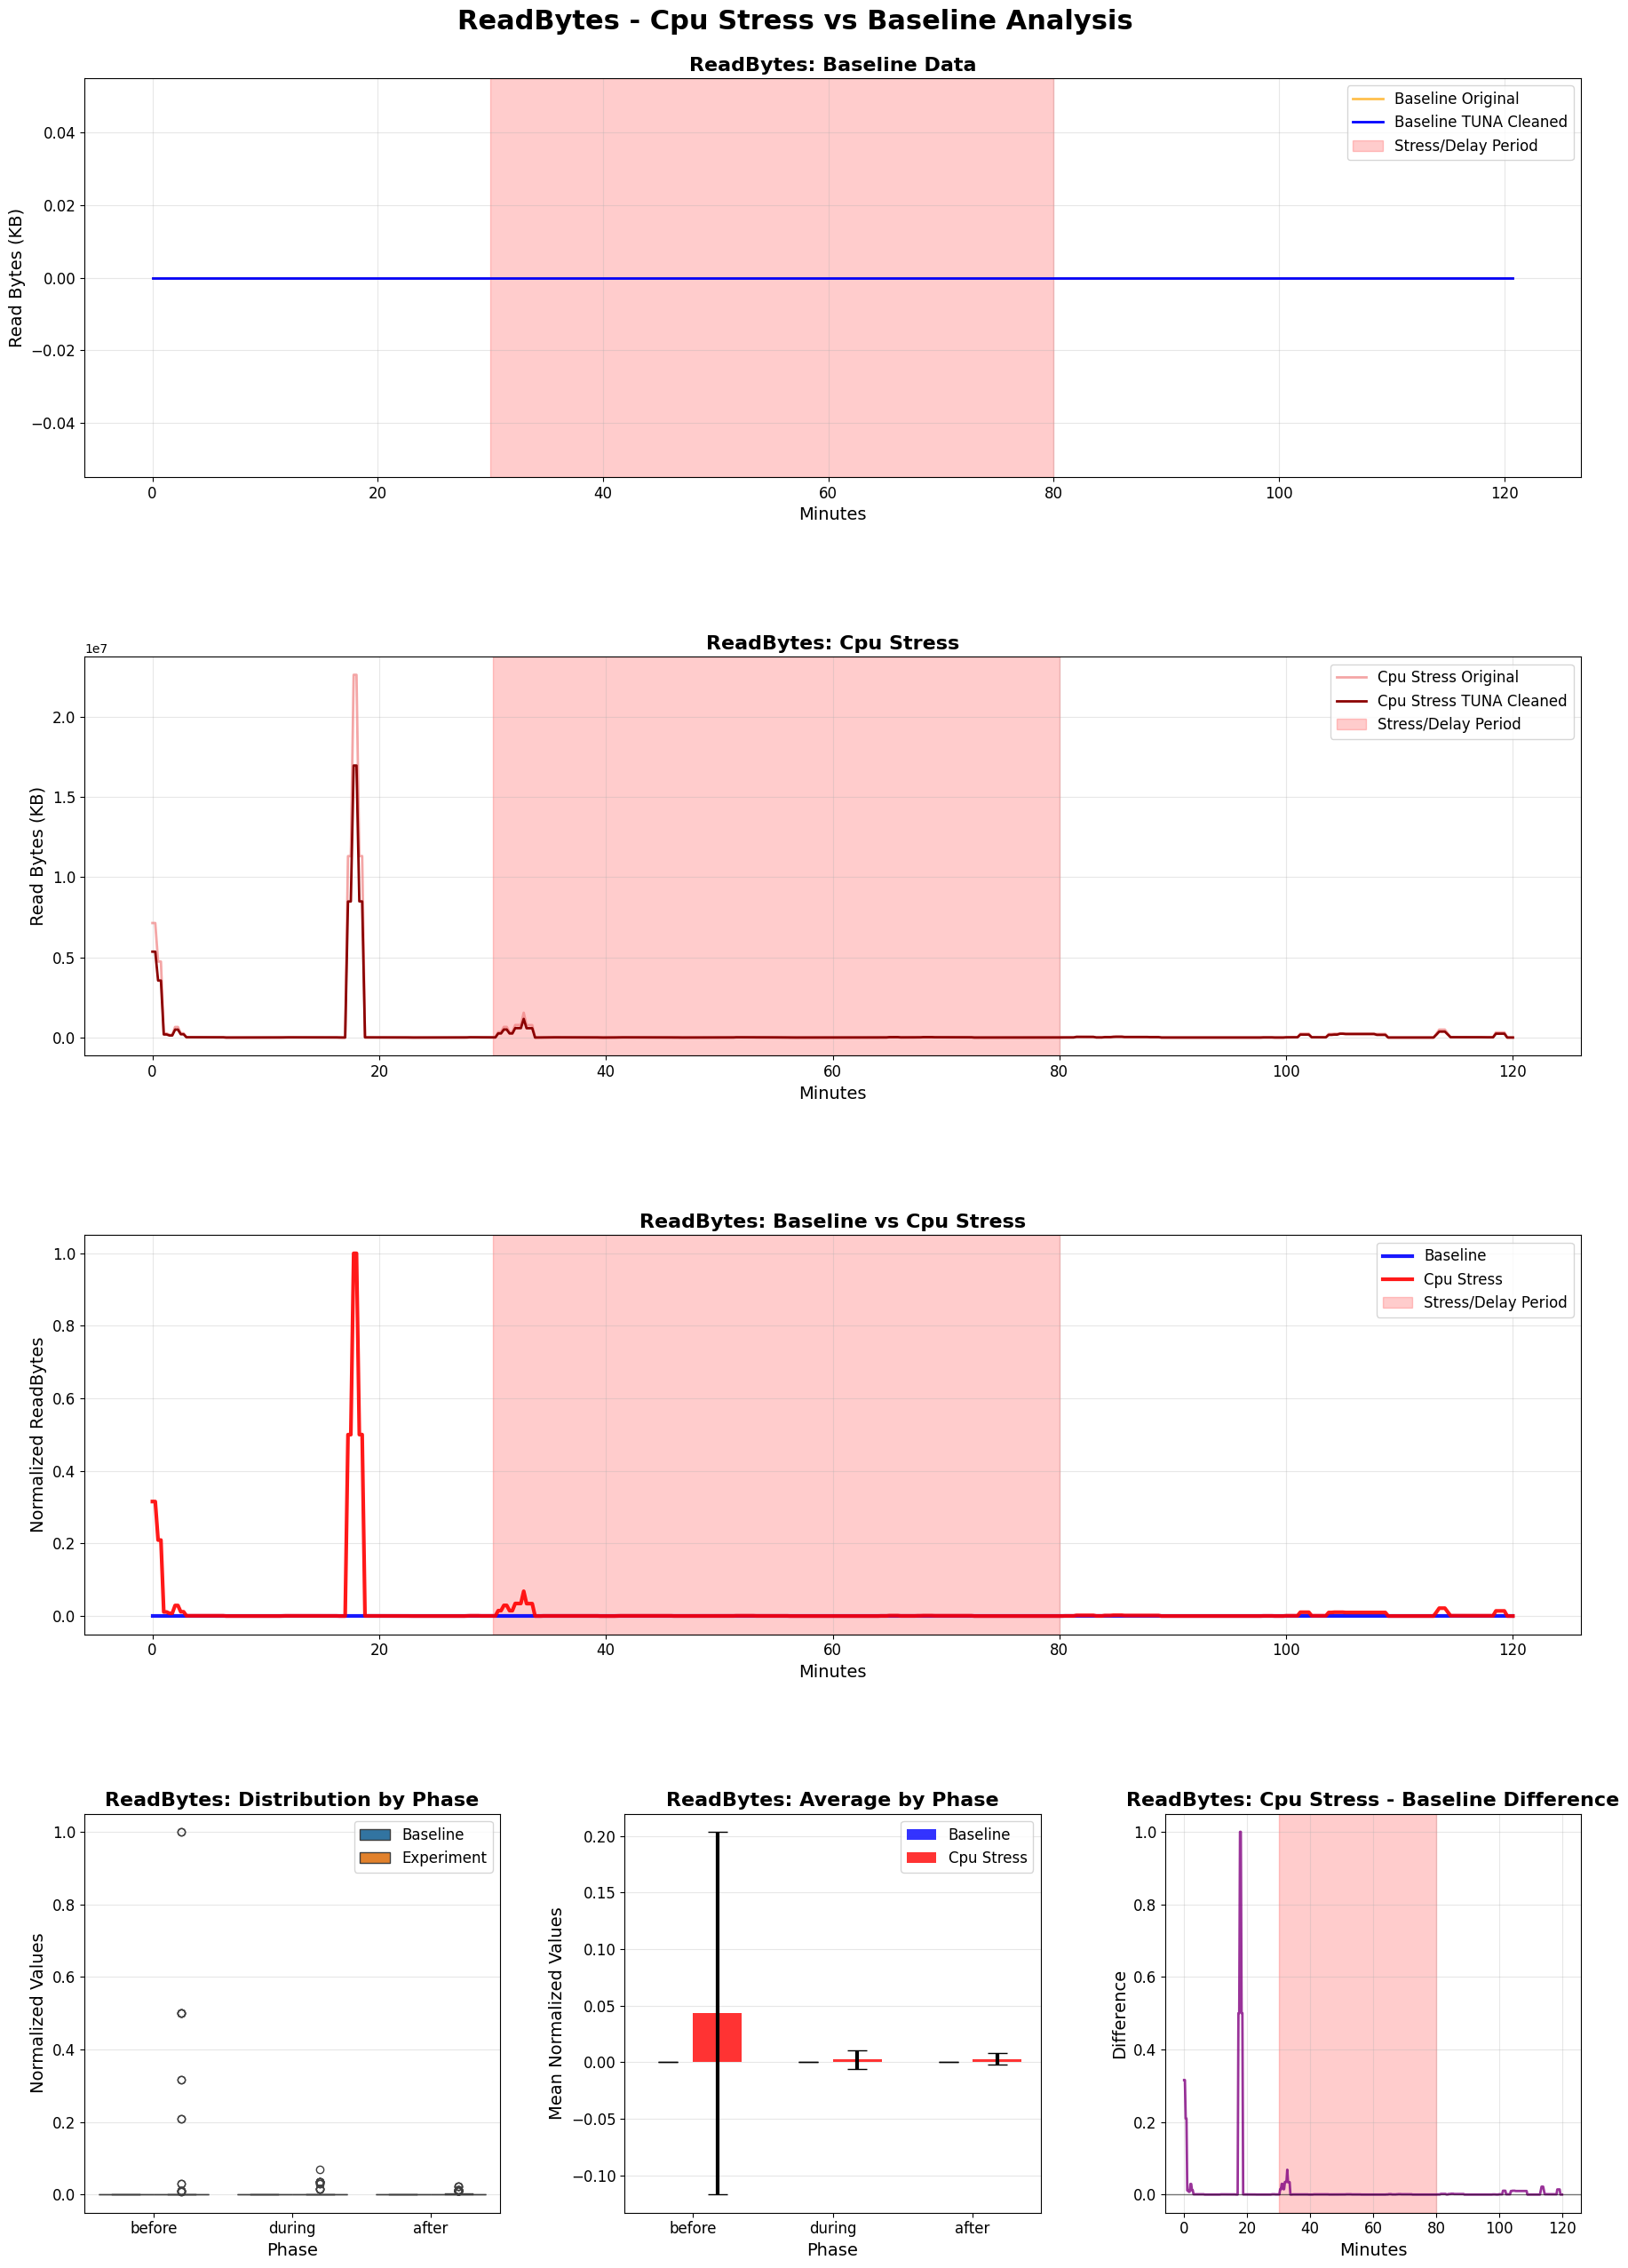


READBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 349 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0029  0.0048  0.0  0.0217
before  0.0433  0.1605  0.0  1.0000
during  0.0022  0.0082  0.0  0.0684

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.96, p=  0.0034 (SIGNIFICANT)
  DURING  : t= -3.83, p=  0.0001 (SIGNIFICANT)
  AFTER   : t= -7.57, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyze

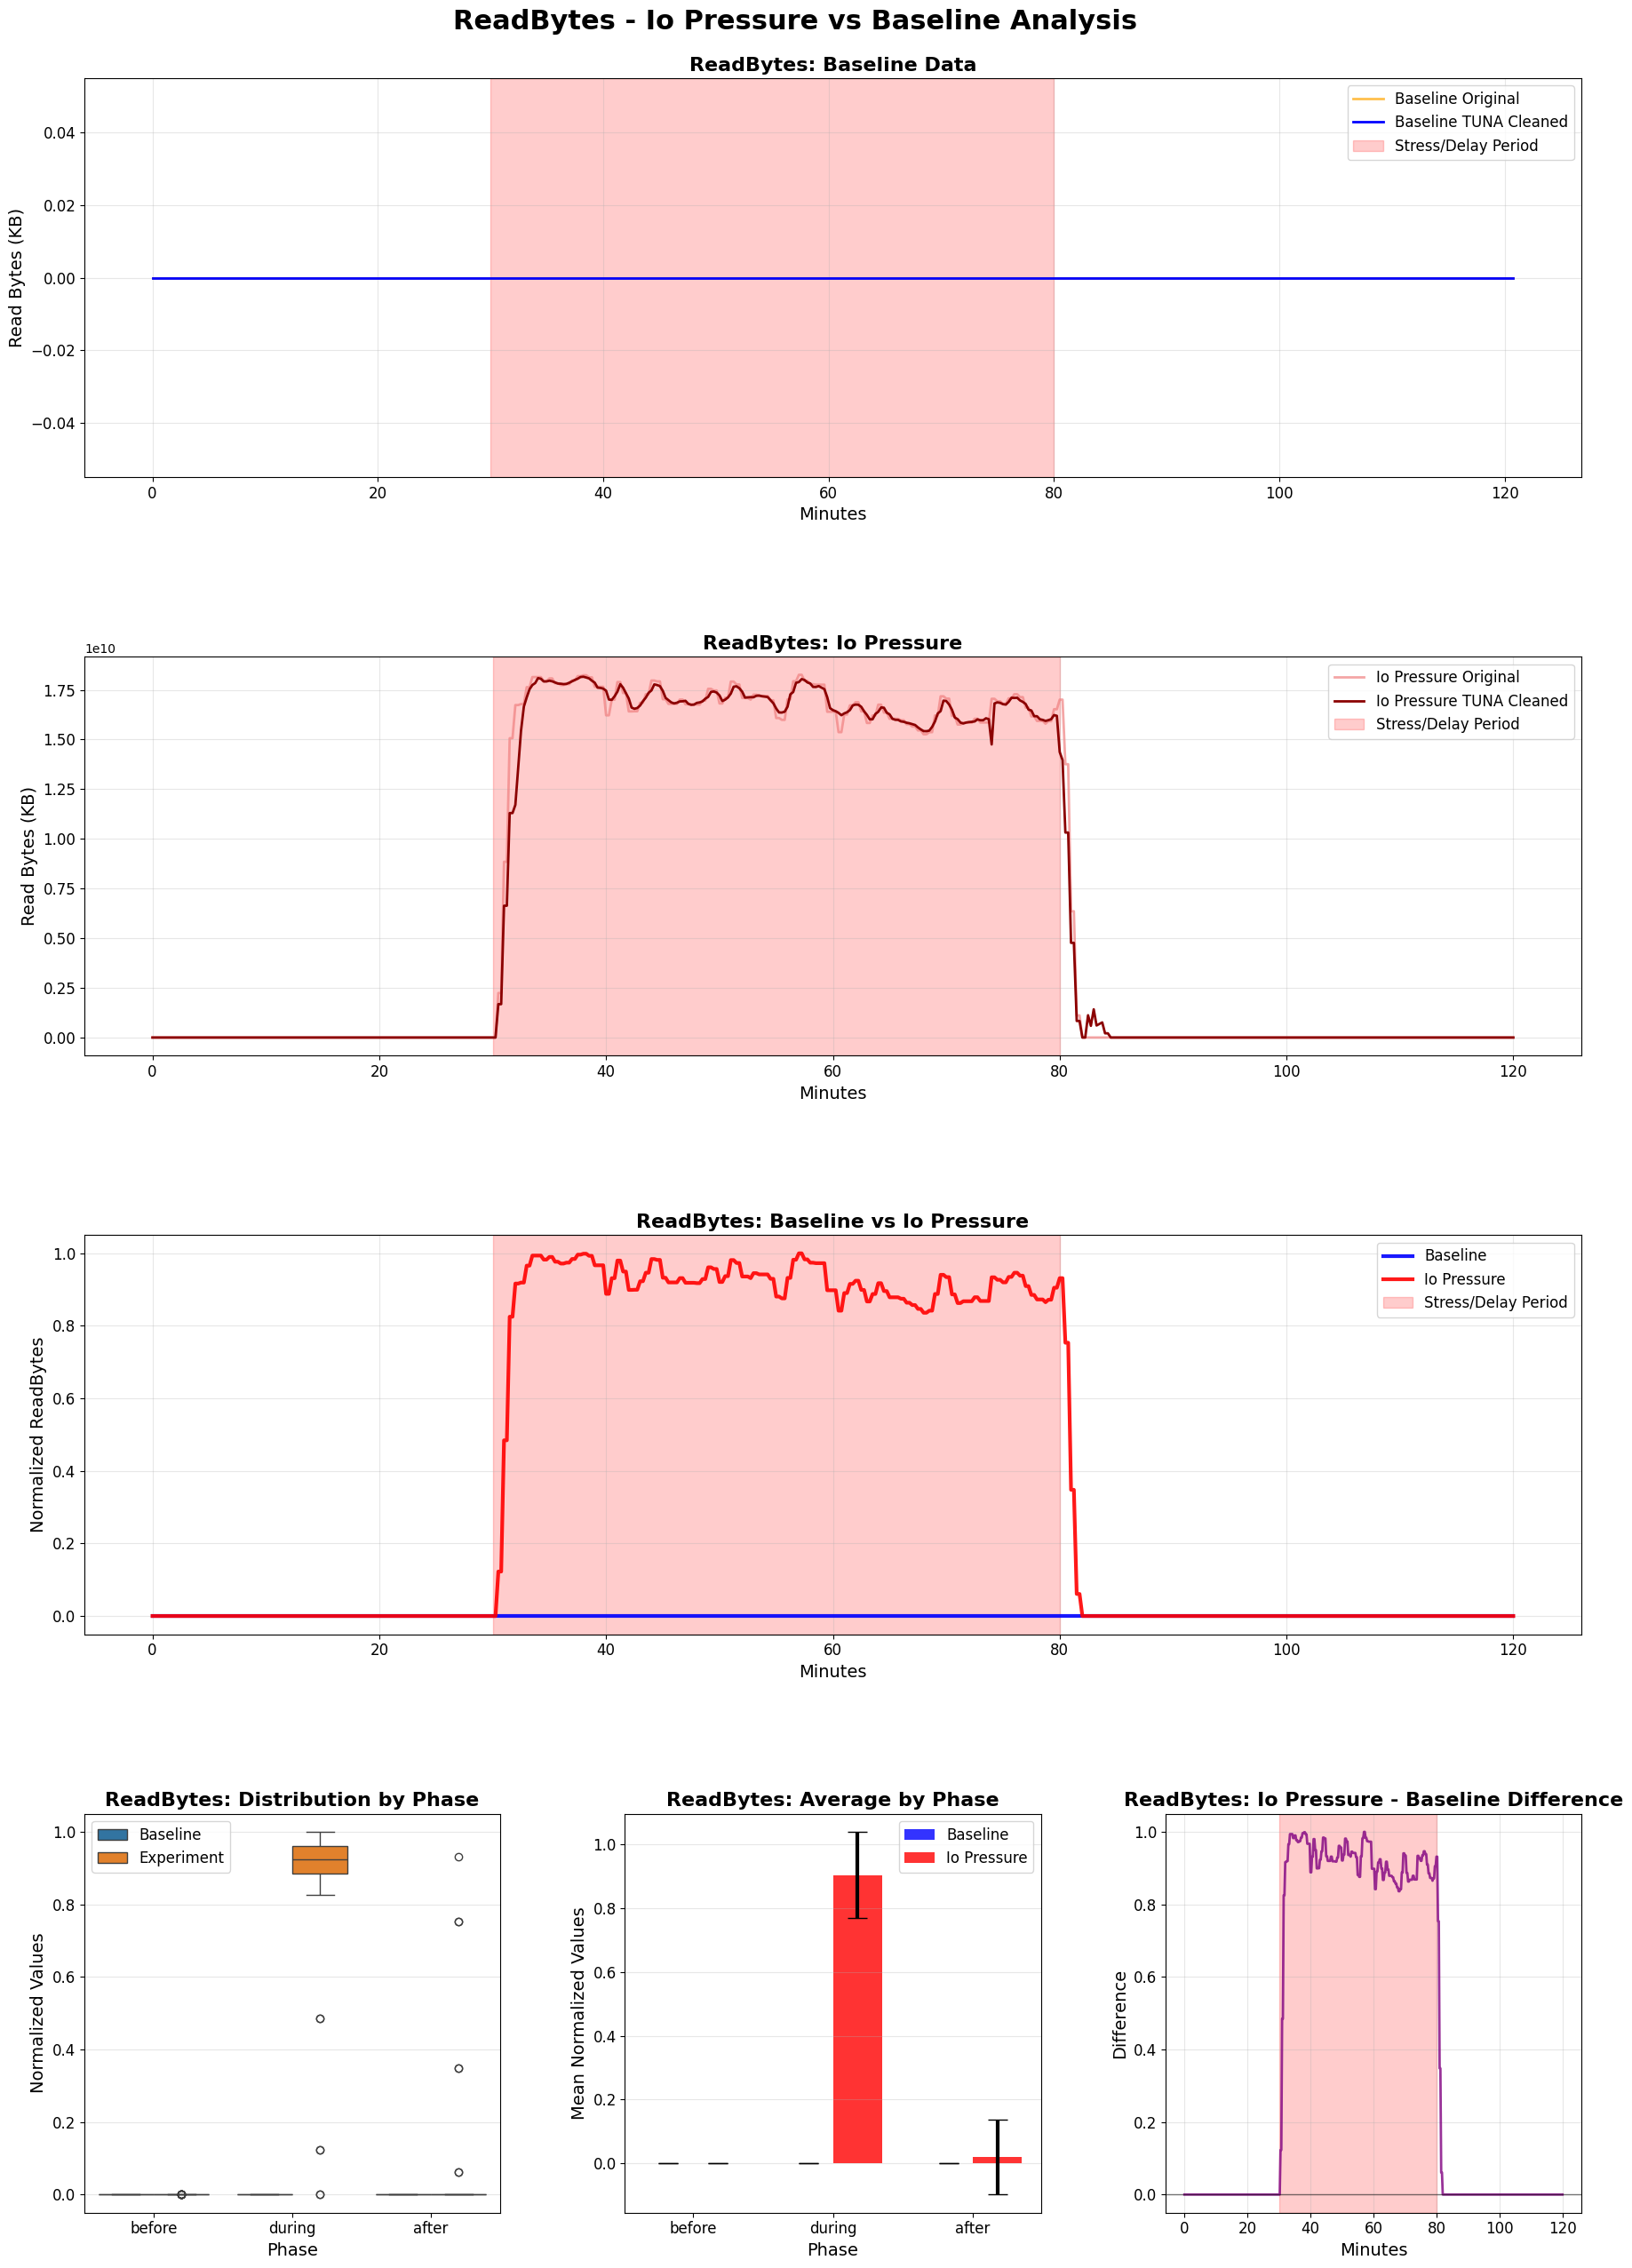


READBYTES - IO PRESSURE VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  IO PRESSURE: 52 outliers removed
    Noise Reduction: 0.8%, Correlation: 0.998
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

IO PRESSURE STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0204  0.1173  0.0  0.9316
before  0.0000  0.0000  0.0  0.0000
during  0.9024  0.1354  0.0  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.35, p=  0.0195 (SIGNIFICANT)
  DURING  : t=-94.50, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -2.20, p=  0.0289 (SIGNIFICANT)

IO PRESSURE IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analy

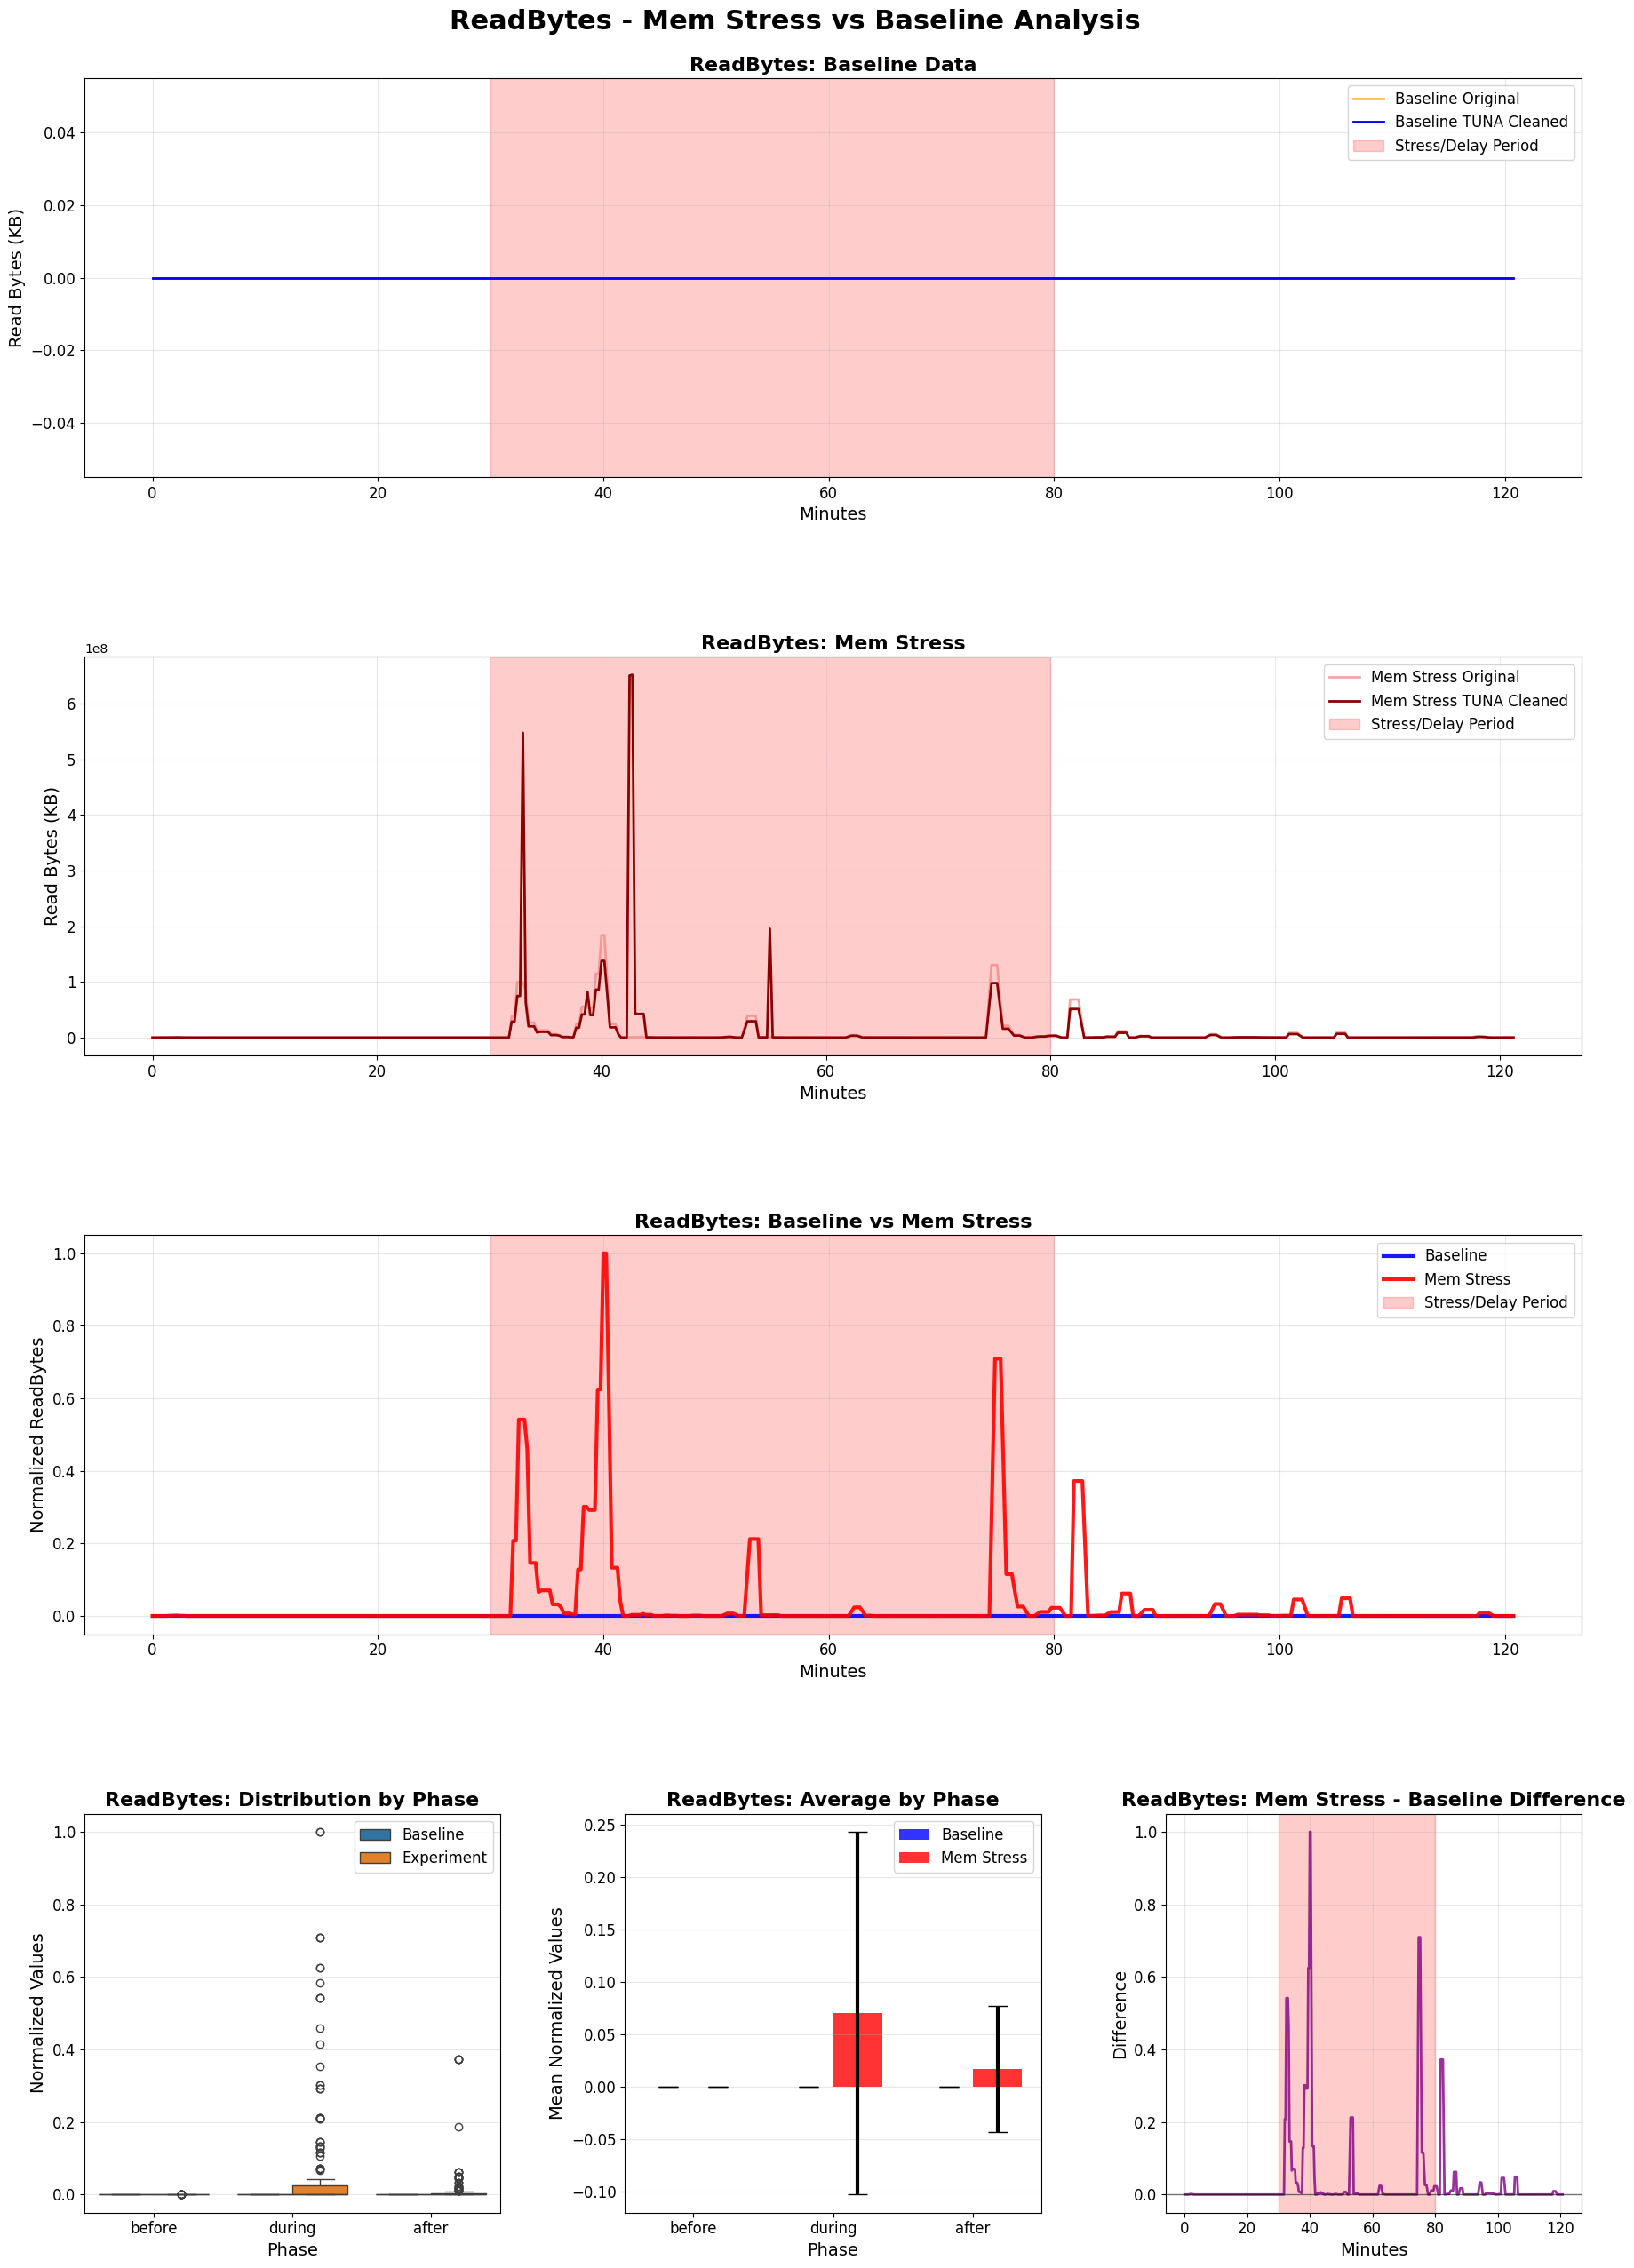


READBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 535 outliers removed
    Noise Reduction: -133.8%, Correlation: 0.387
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0168  0.0601  0.0  0.3724
before  0.0000  0.0002  0.0  0.0014
during  0.0701  0.1729  0.0  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.48, p=  0.0139 (SIGNIFICANT)
  DURING  : t= -5.75, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.58, p=  0.0004 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analy

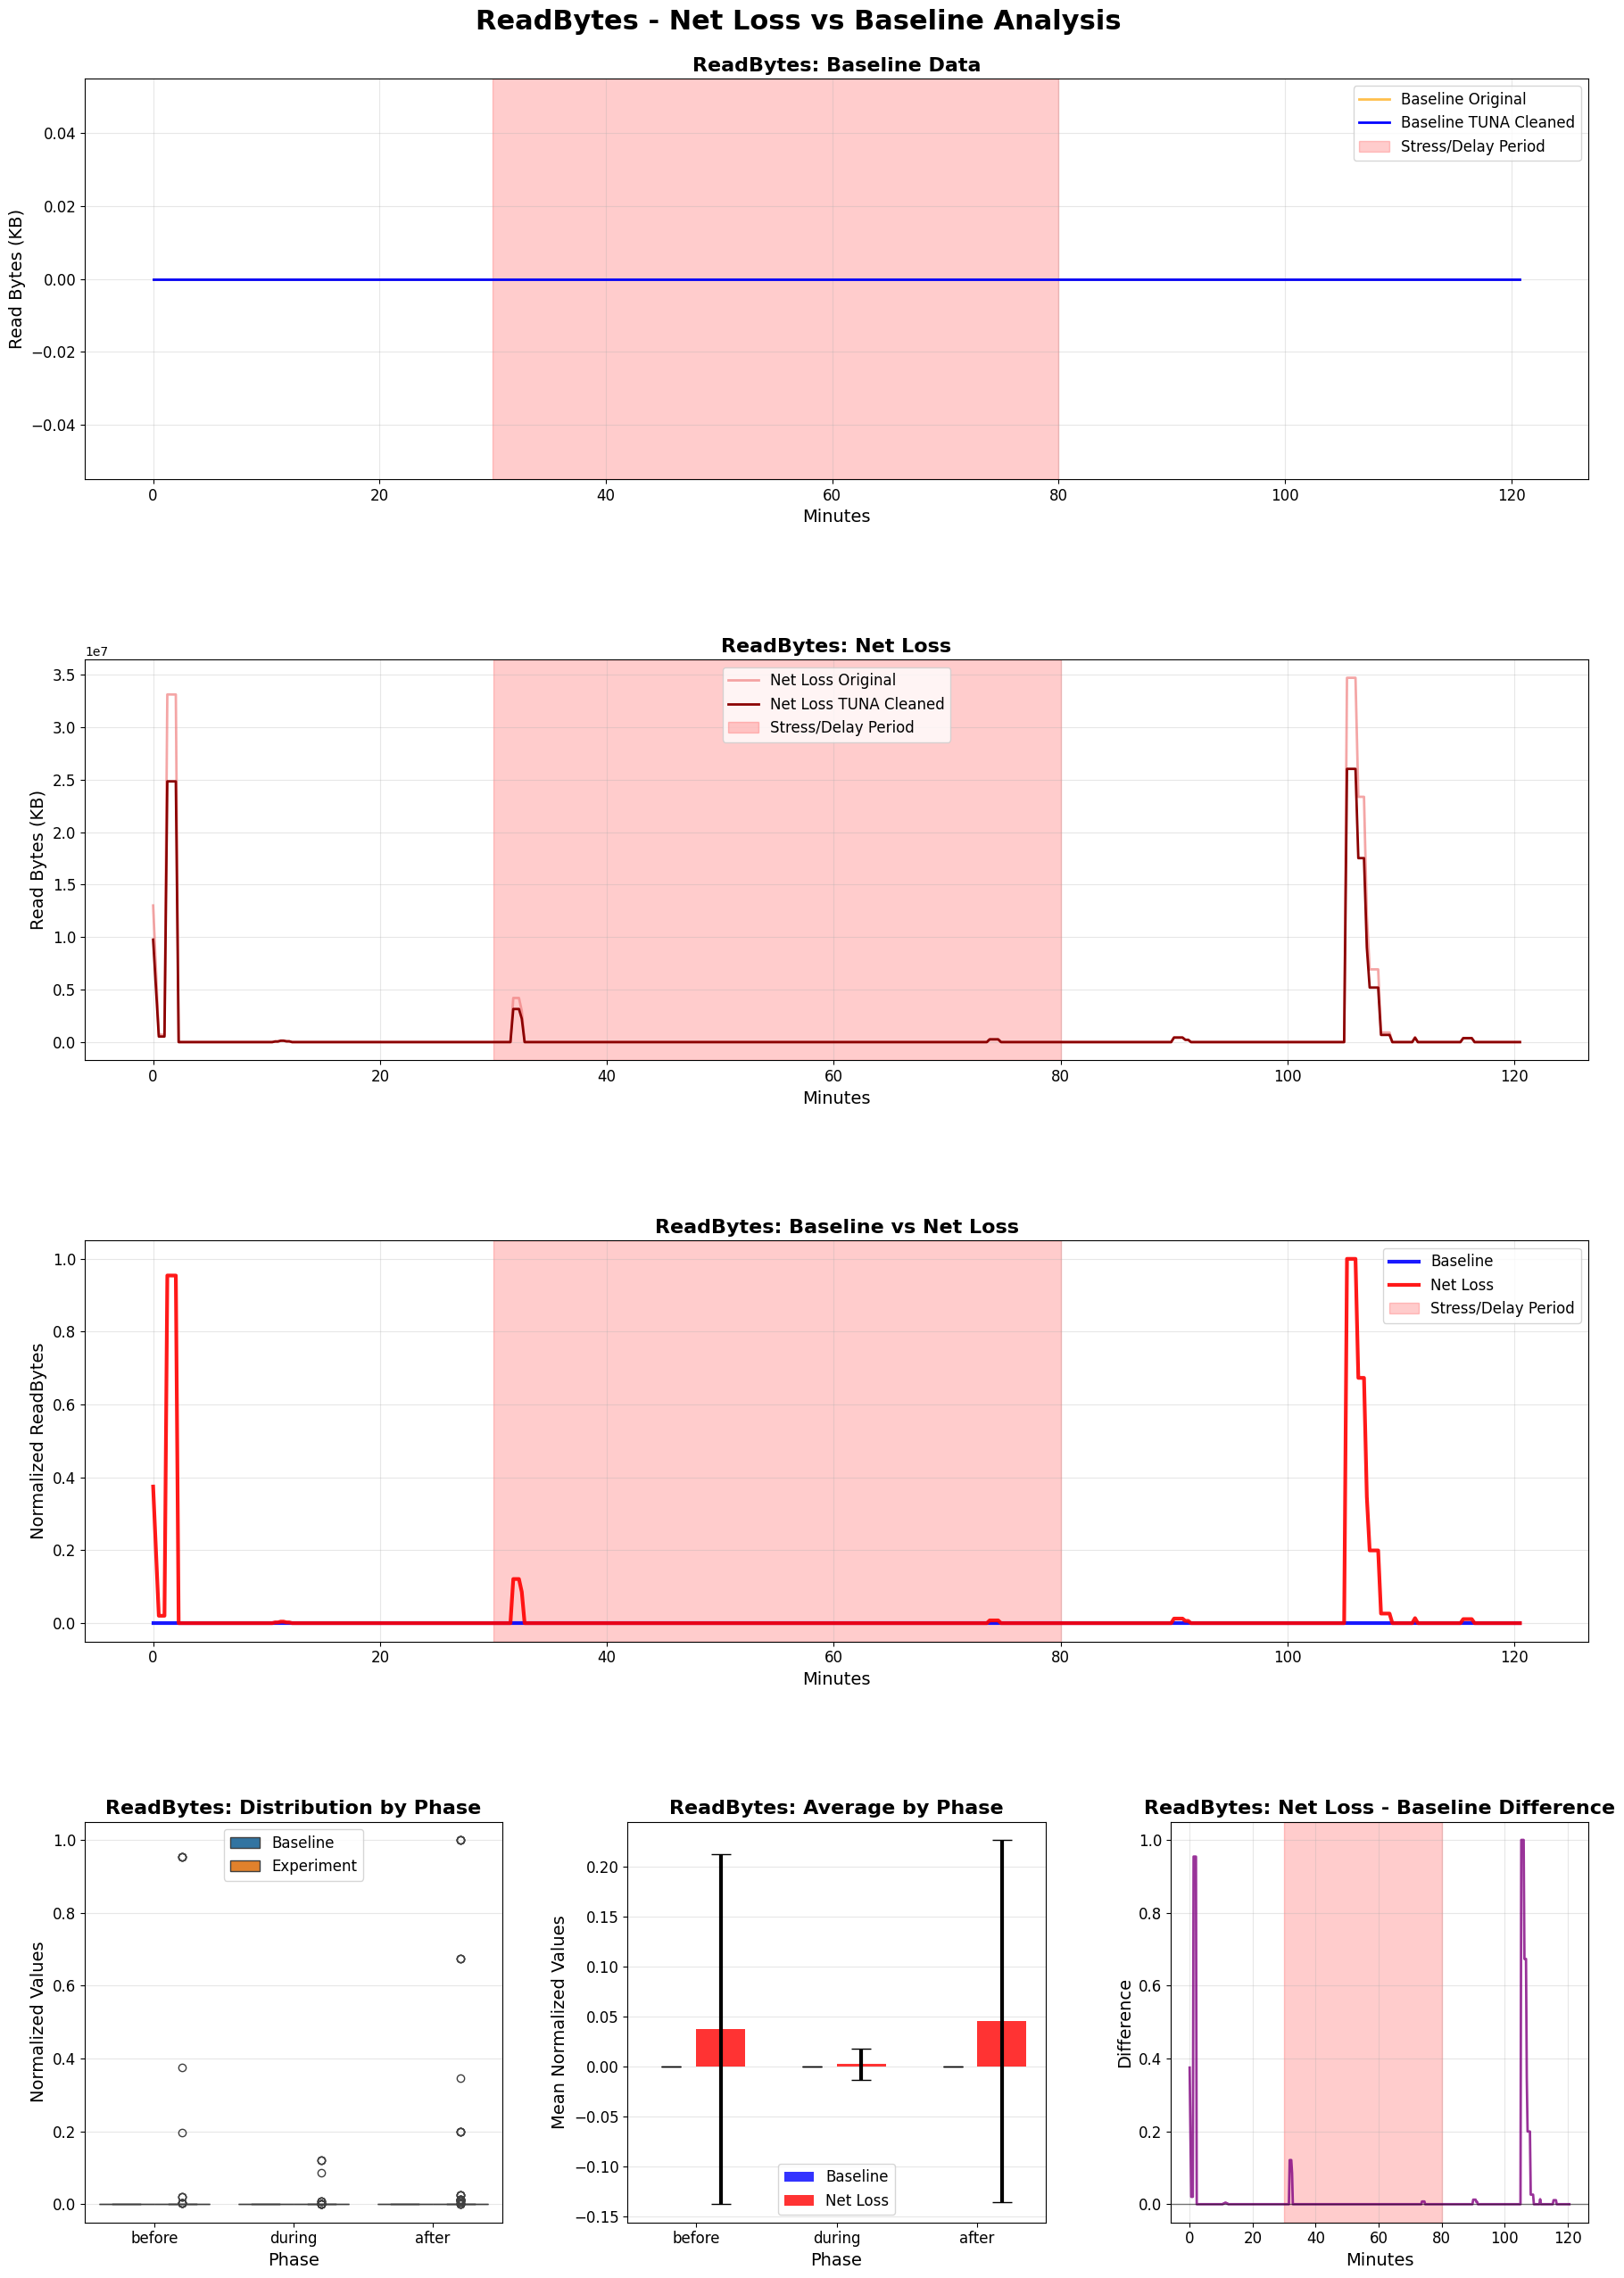


READBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 138 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0456  0.1815  0.0  1.0000
before  0.0372  0.1753  0.0  0.9543
during  0.0024  0.0159  0.0  0.1211

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.33, p=  0.0208 (SIGNIFICANT)
  DURING  : t= -2.14, p=  0.0331 (SIGNIFICANT)
  AFTER   : t= -3.20, p=  0.0015 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['ope

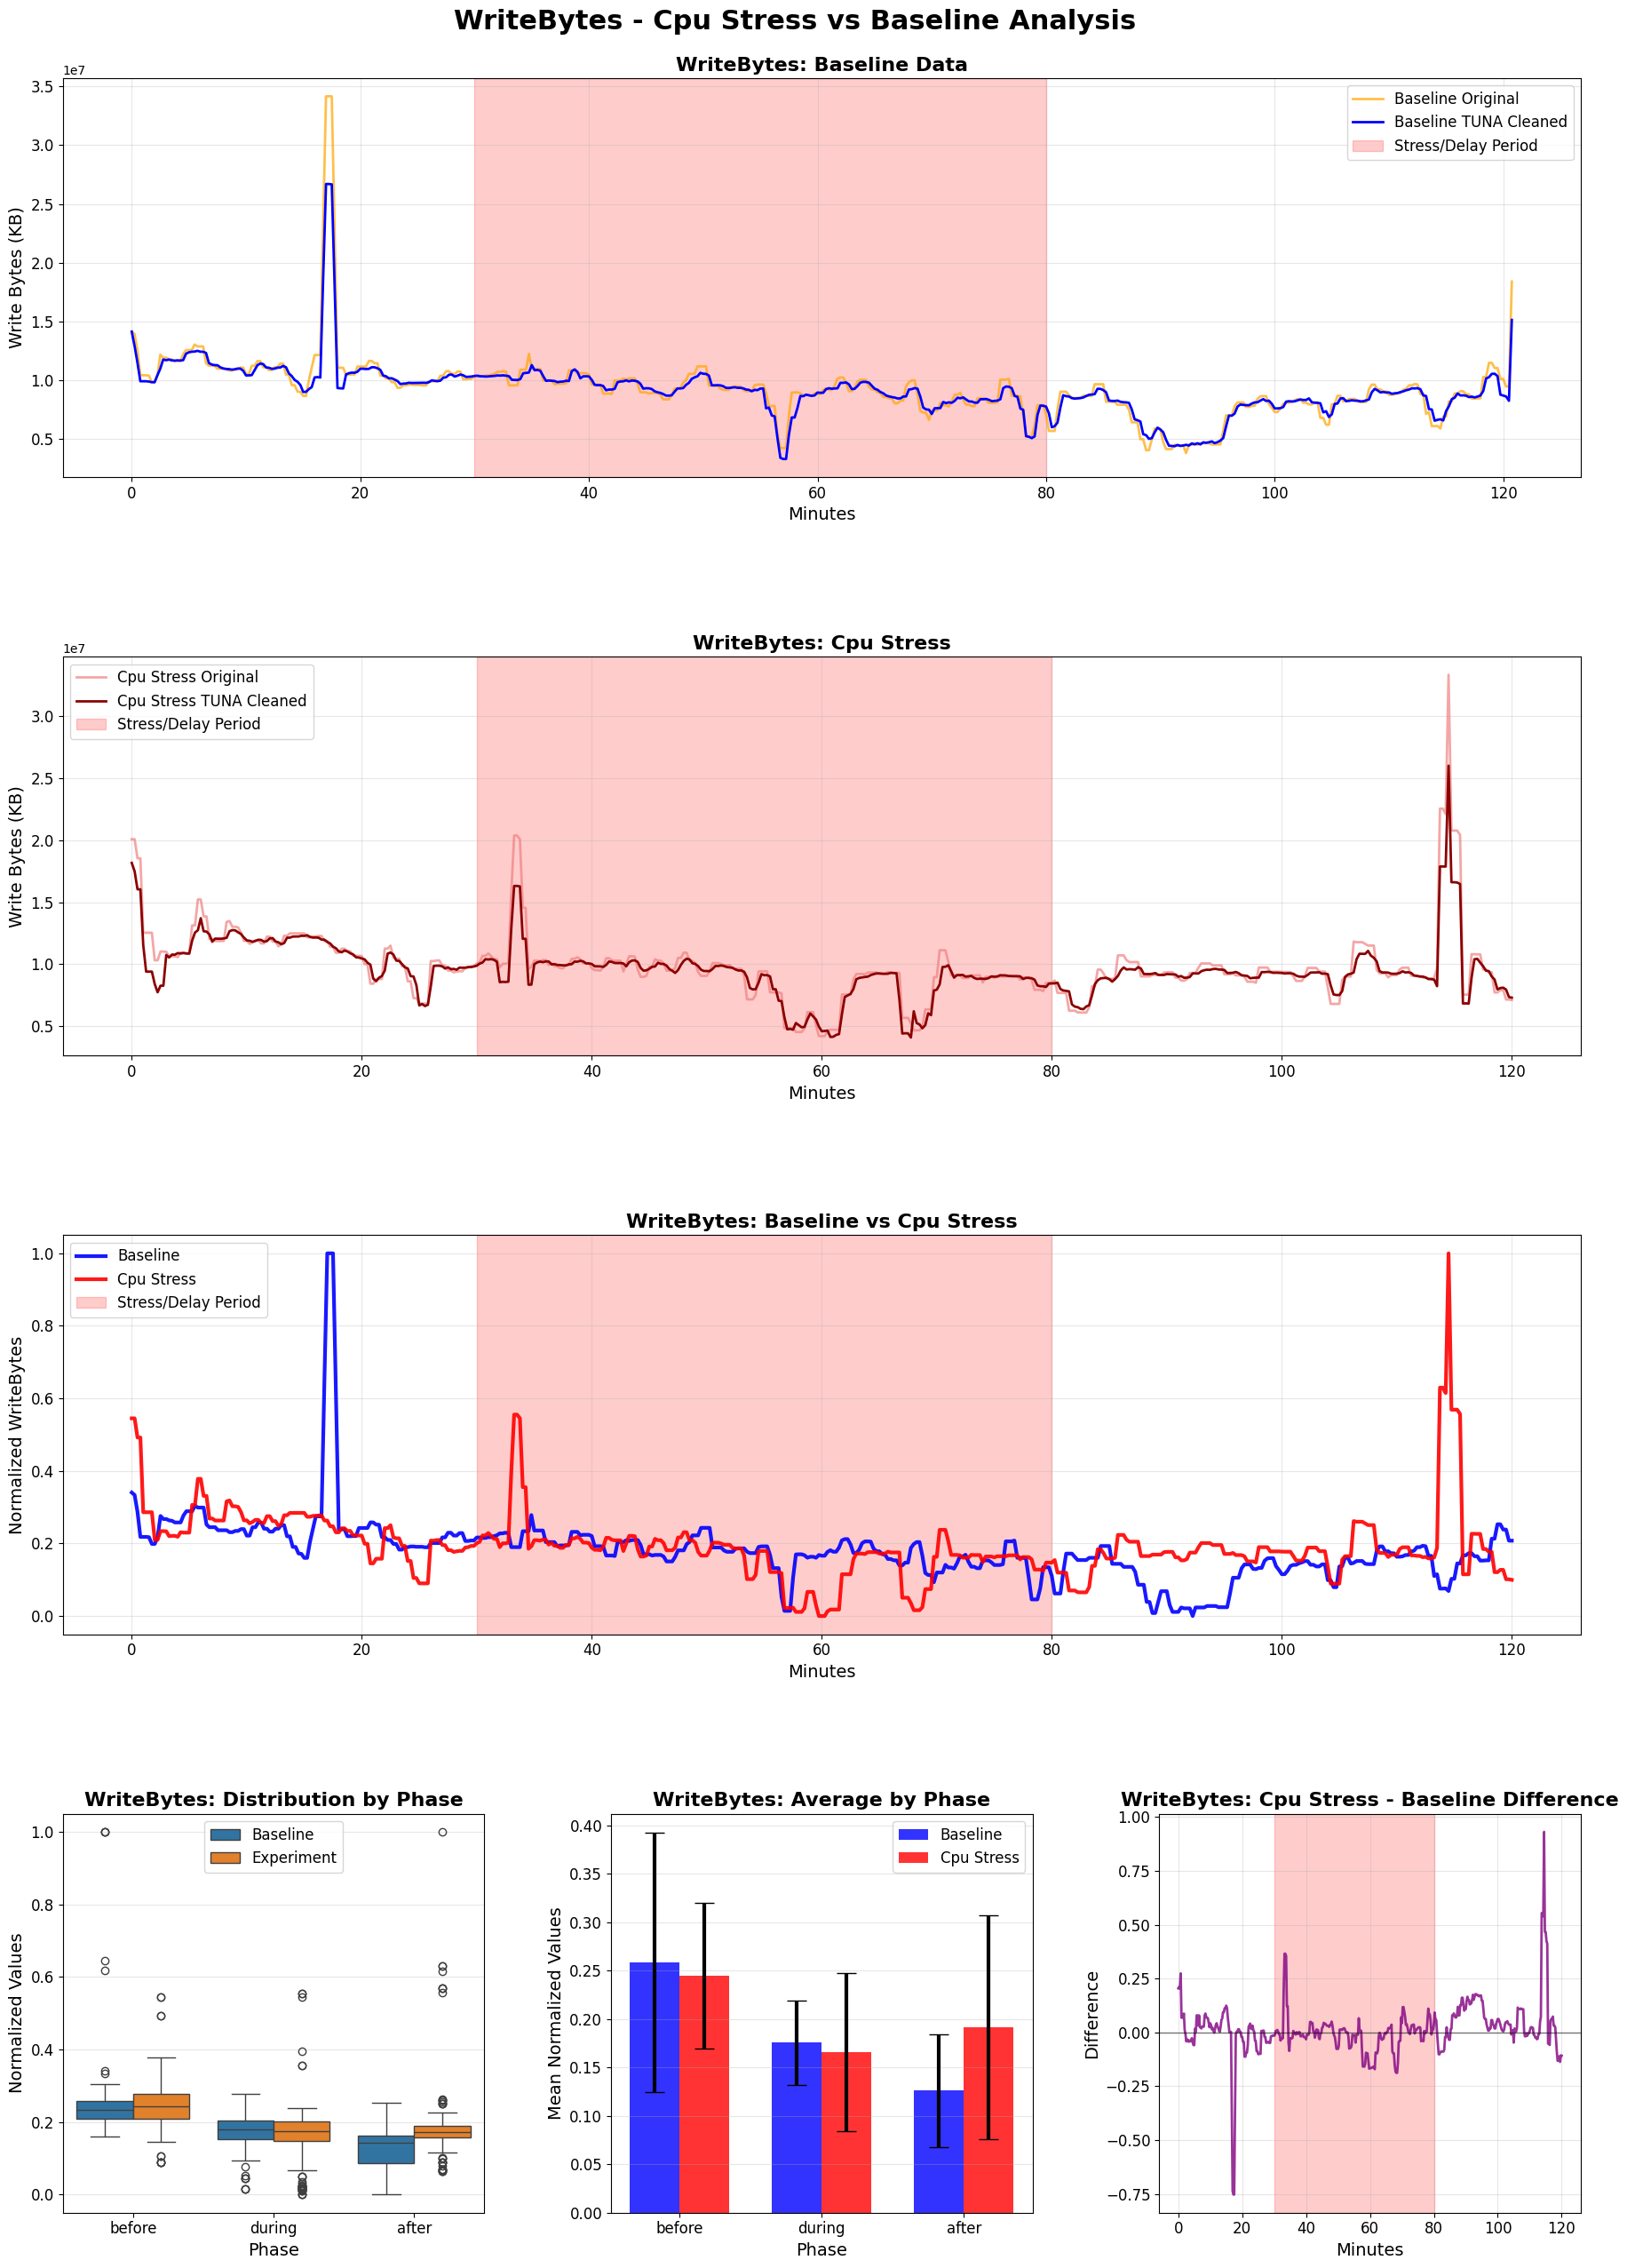


WRITEBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 148 outliers removed
    Noise Reduction: 21.1%, Correlation: 0.957
  BASELINE: 83 outliers removed
    Noise Reduction: 19.5%, Correlation: 0.970

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1260  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1911  0.1156  0.0652  1.0000
before  0.2448  0.0755  0.0901  0.5450
during  0.1657  0.0818  0.0000  0.5553

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  0.97, p=  0.3350 (NOT SIGNIFICANT)
  DURING  : t=  1.51, p=  0.1316 (NOT SIGNIFICANT)
  AFTER   : t= -6.36, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   -5.25% (DECREASE)
  DURING  :   -5.63% (DECREASE)
  AFTER   :  +51.65% (INCREASE)

DISK I/O METRICS

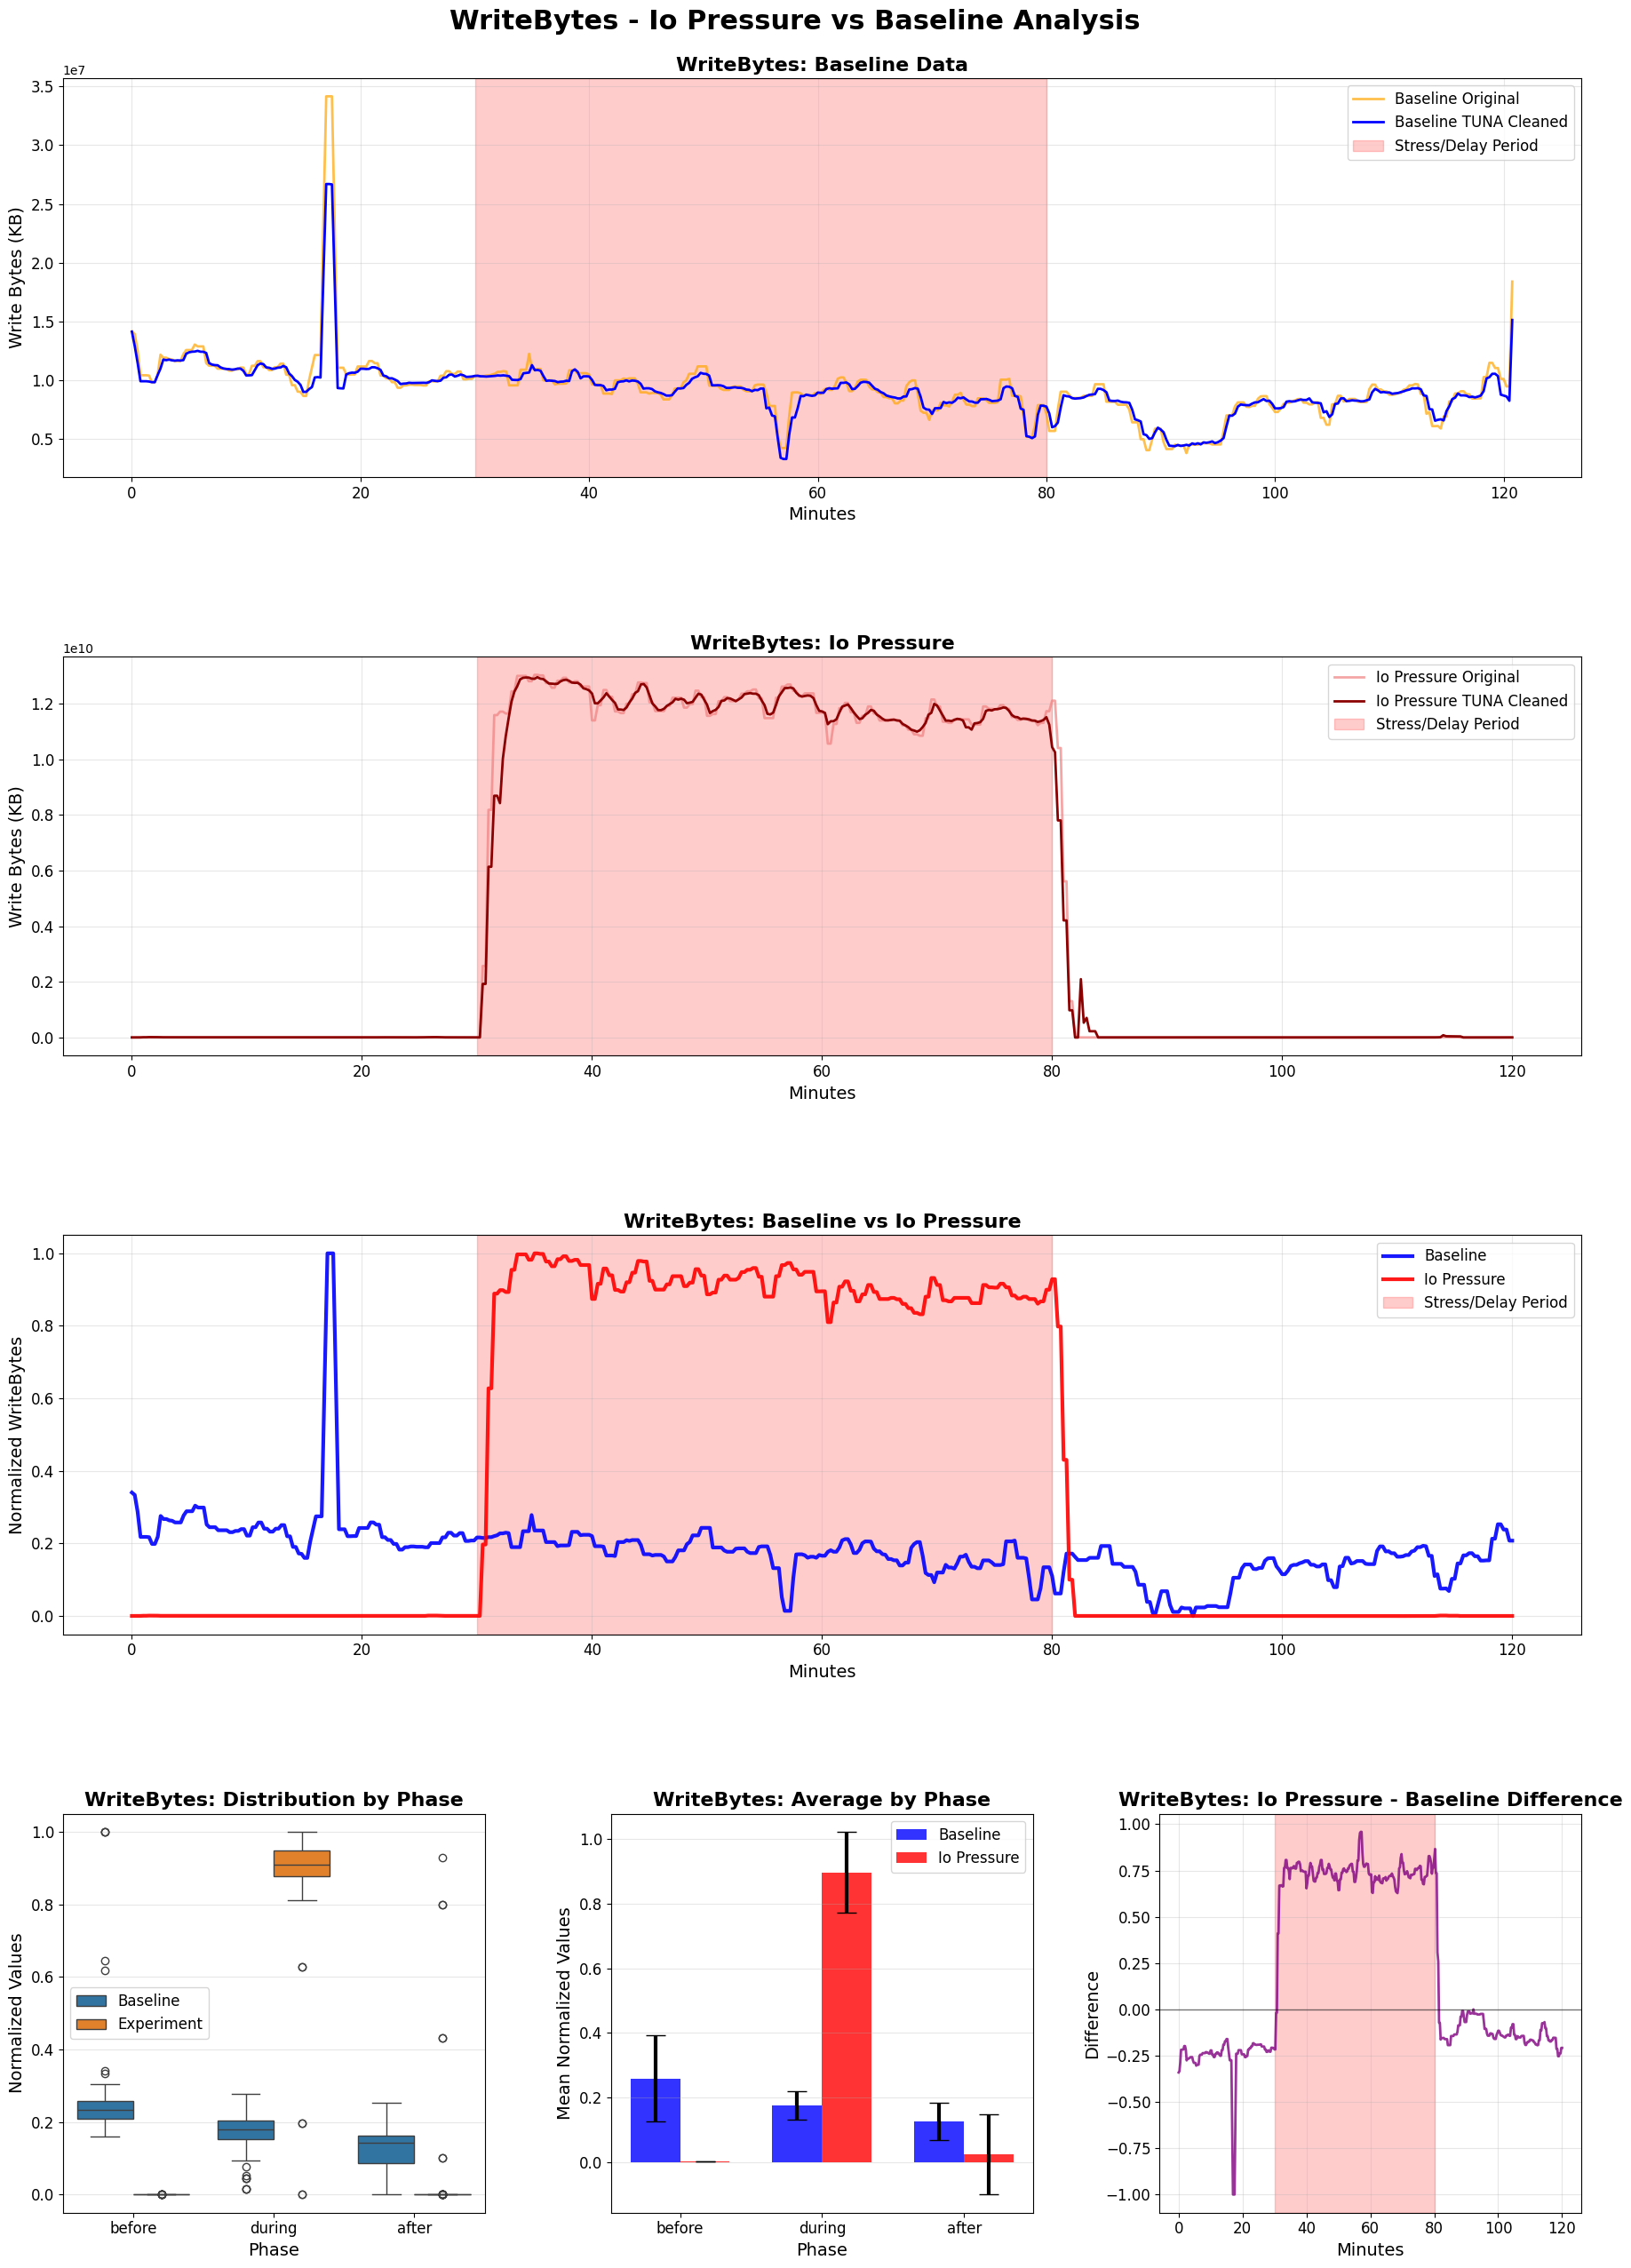


WRITEBYTES - IO PRESSURE VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  IO PRESSURE: 114 outliers removed
    Noise Reduction: 0.8%, Correlation: 0.998
  BASELINE: 83 outliers removed
    Noise Reduction: 19.5%, Correlation: 0.970

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1260  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0227  0.1240  0.0000  0.9287
before  0.0005  0.0002  0.0003  0.0012
during  0.8968  0.1256  0.0004  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 21.06, p=  0.0000 (SIGNIFICANT)
  DURING  : t=-76.93, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  9.54, p=  0.0000 (SIGNIFICANT)

IO PRESSURE IMPACT:
  BEFORE  :  -99.79% (DECREASE)
  DURING  : +410.73% (INCREASE)
  AFTER   :  -81.99% (DECREASE)

DISK I/O METRICS DETA

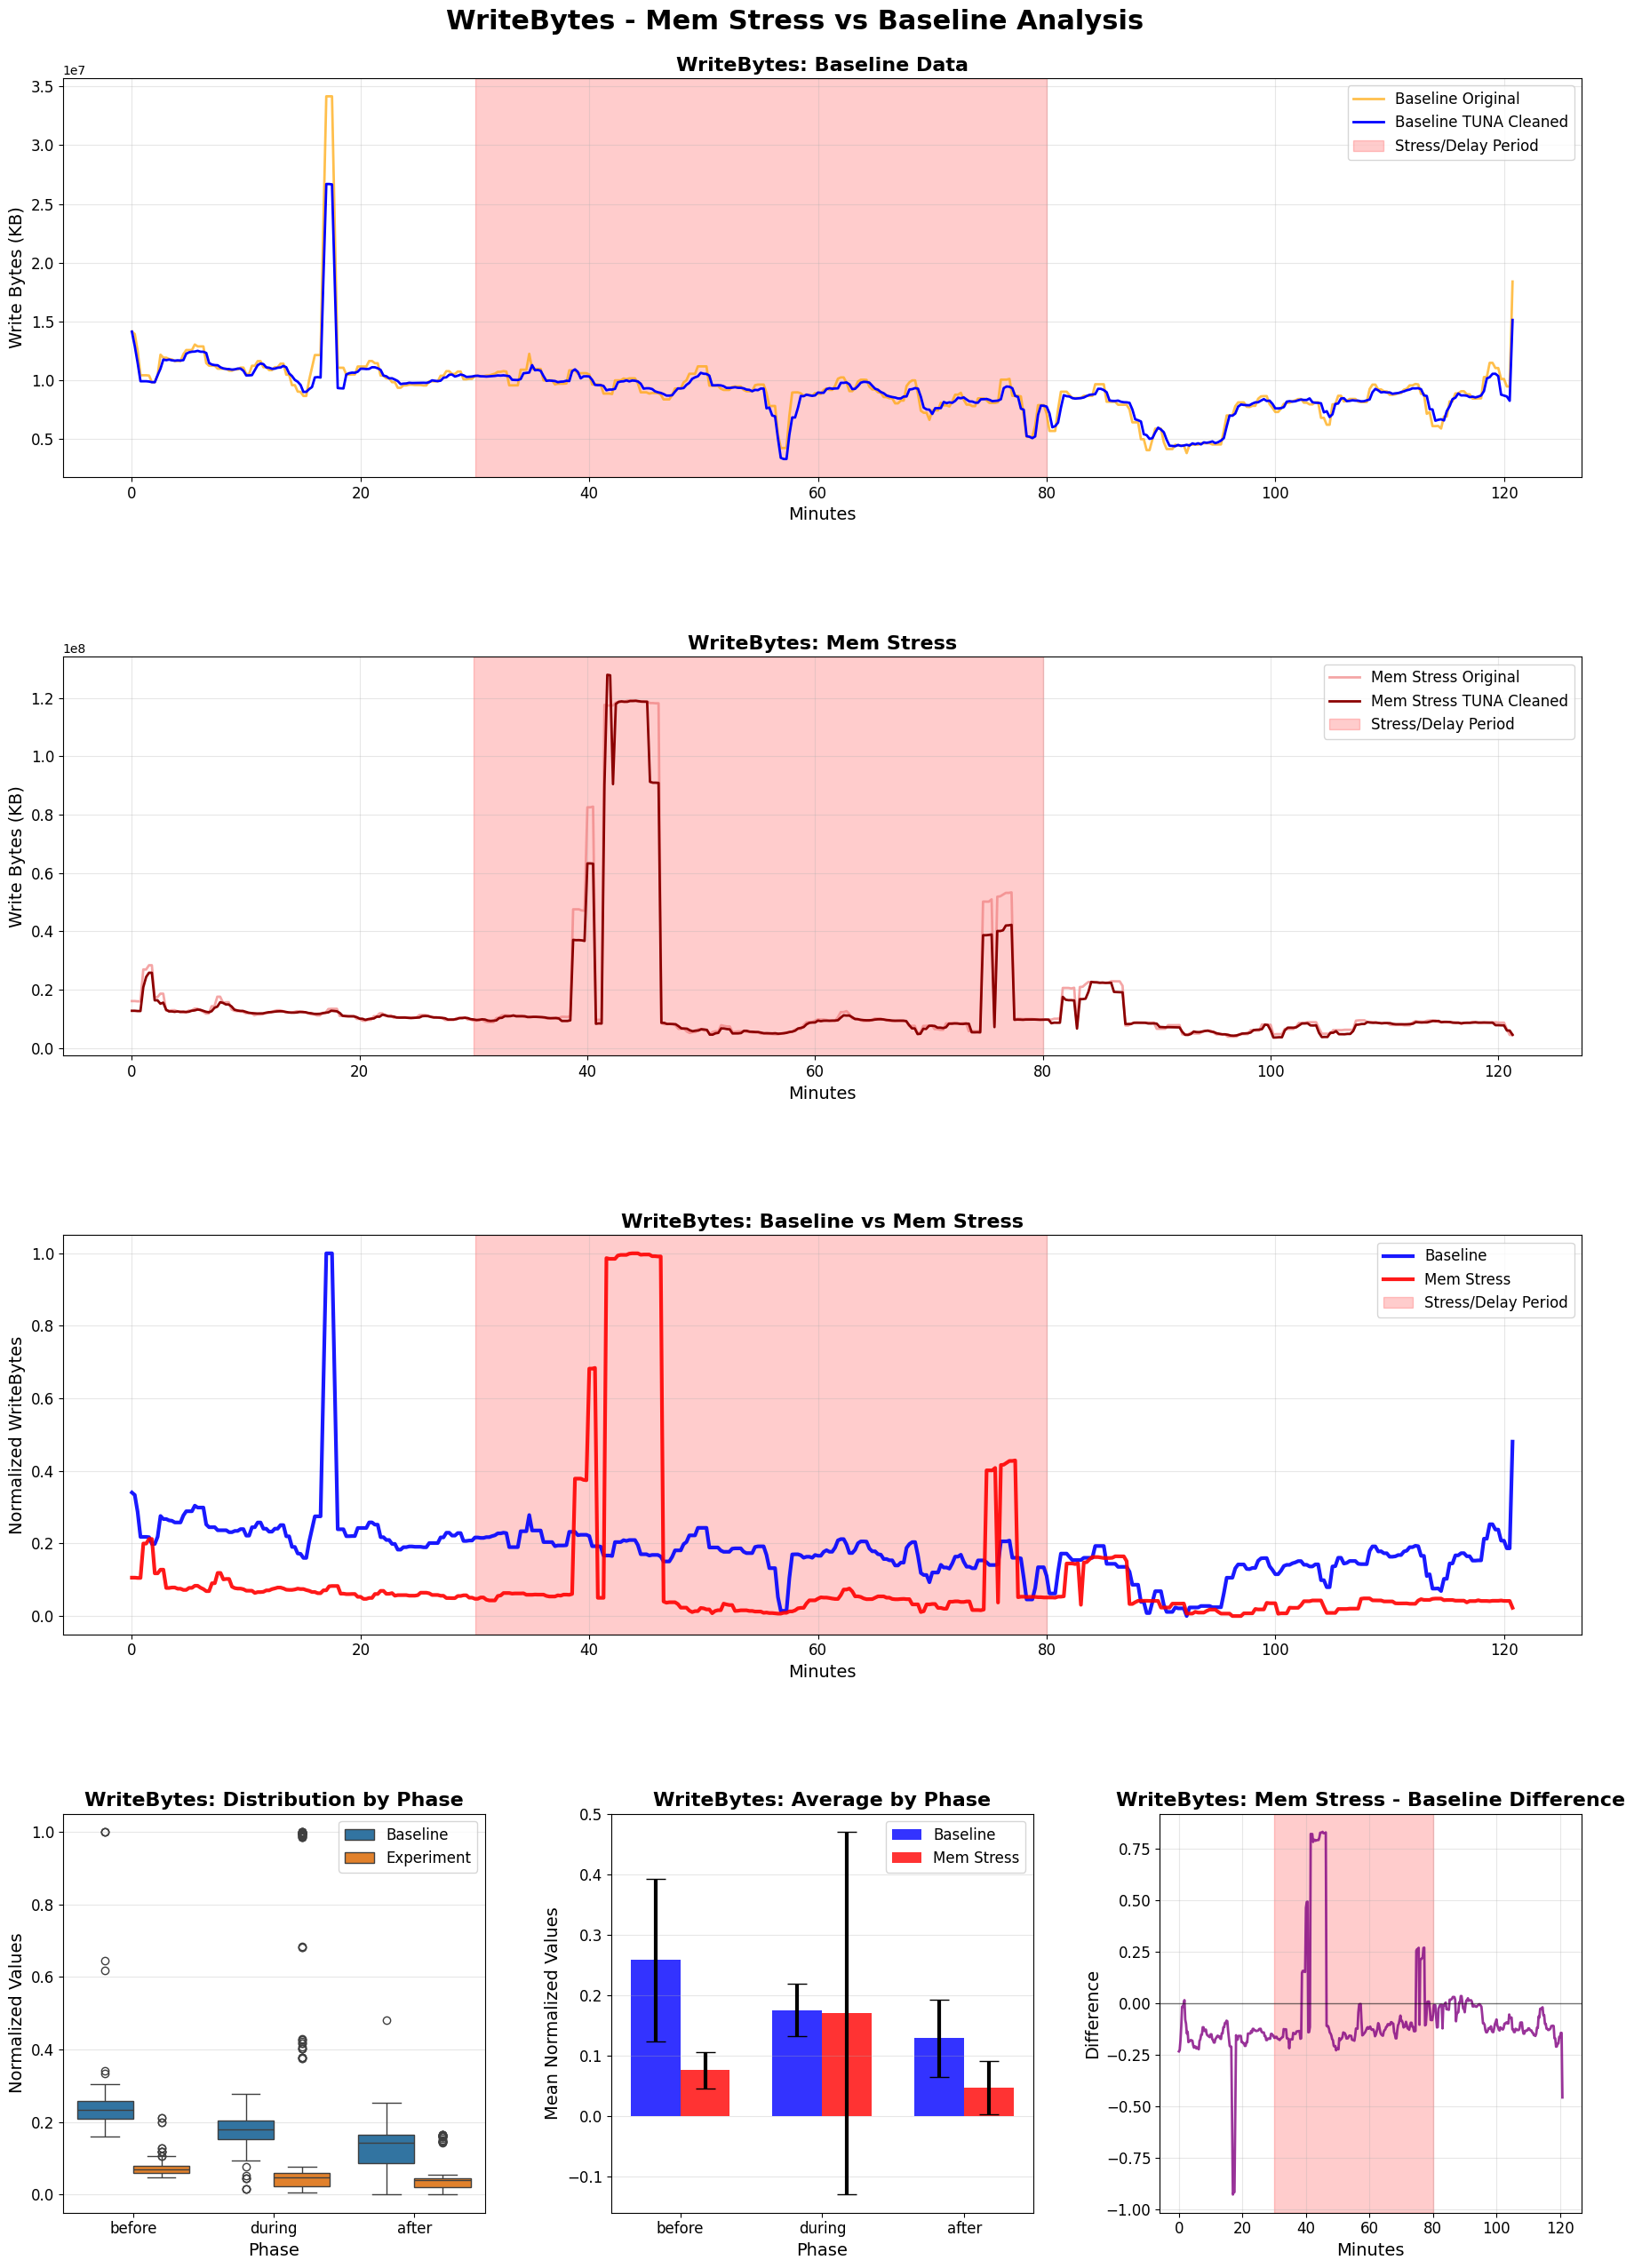


WRITEBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 188 outliers removed
    Noise Reduction: 8.1%, Correlation: 0.988
  BASELINE: 83 outliers removed
    Noise Reduction: 19.5%, Correlation: 0.970

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

MEM STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0469  0.0444  0.0000  0.1647
before  0.0761  0.0298  0.0473  0.2124
during  0.1704  0.3004  0.0066  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 14.53, p=  0.0000 (SIGNIFICANT)
  DURING  : t=  0.24, p=  0.8086 (NOT SIGNIFICANT)
  AFTER   : t= 13.40, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :  -70.53% (DECREASE)
  DURING  :   -2.95% (DECREASE)
  AFTER   :  -63.62% (DECREASE)

DISK I/O METRICS DETA

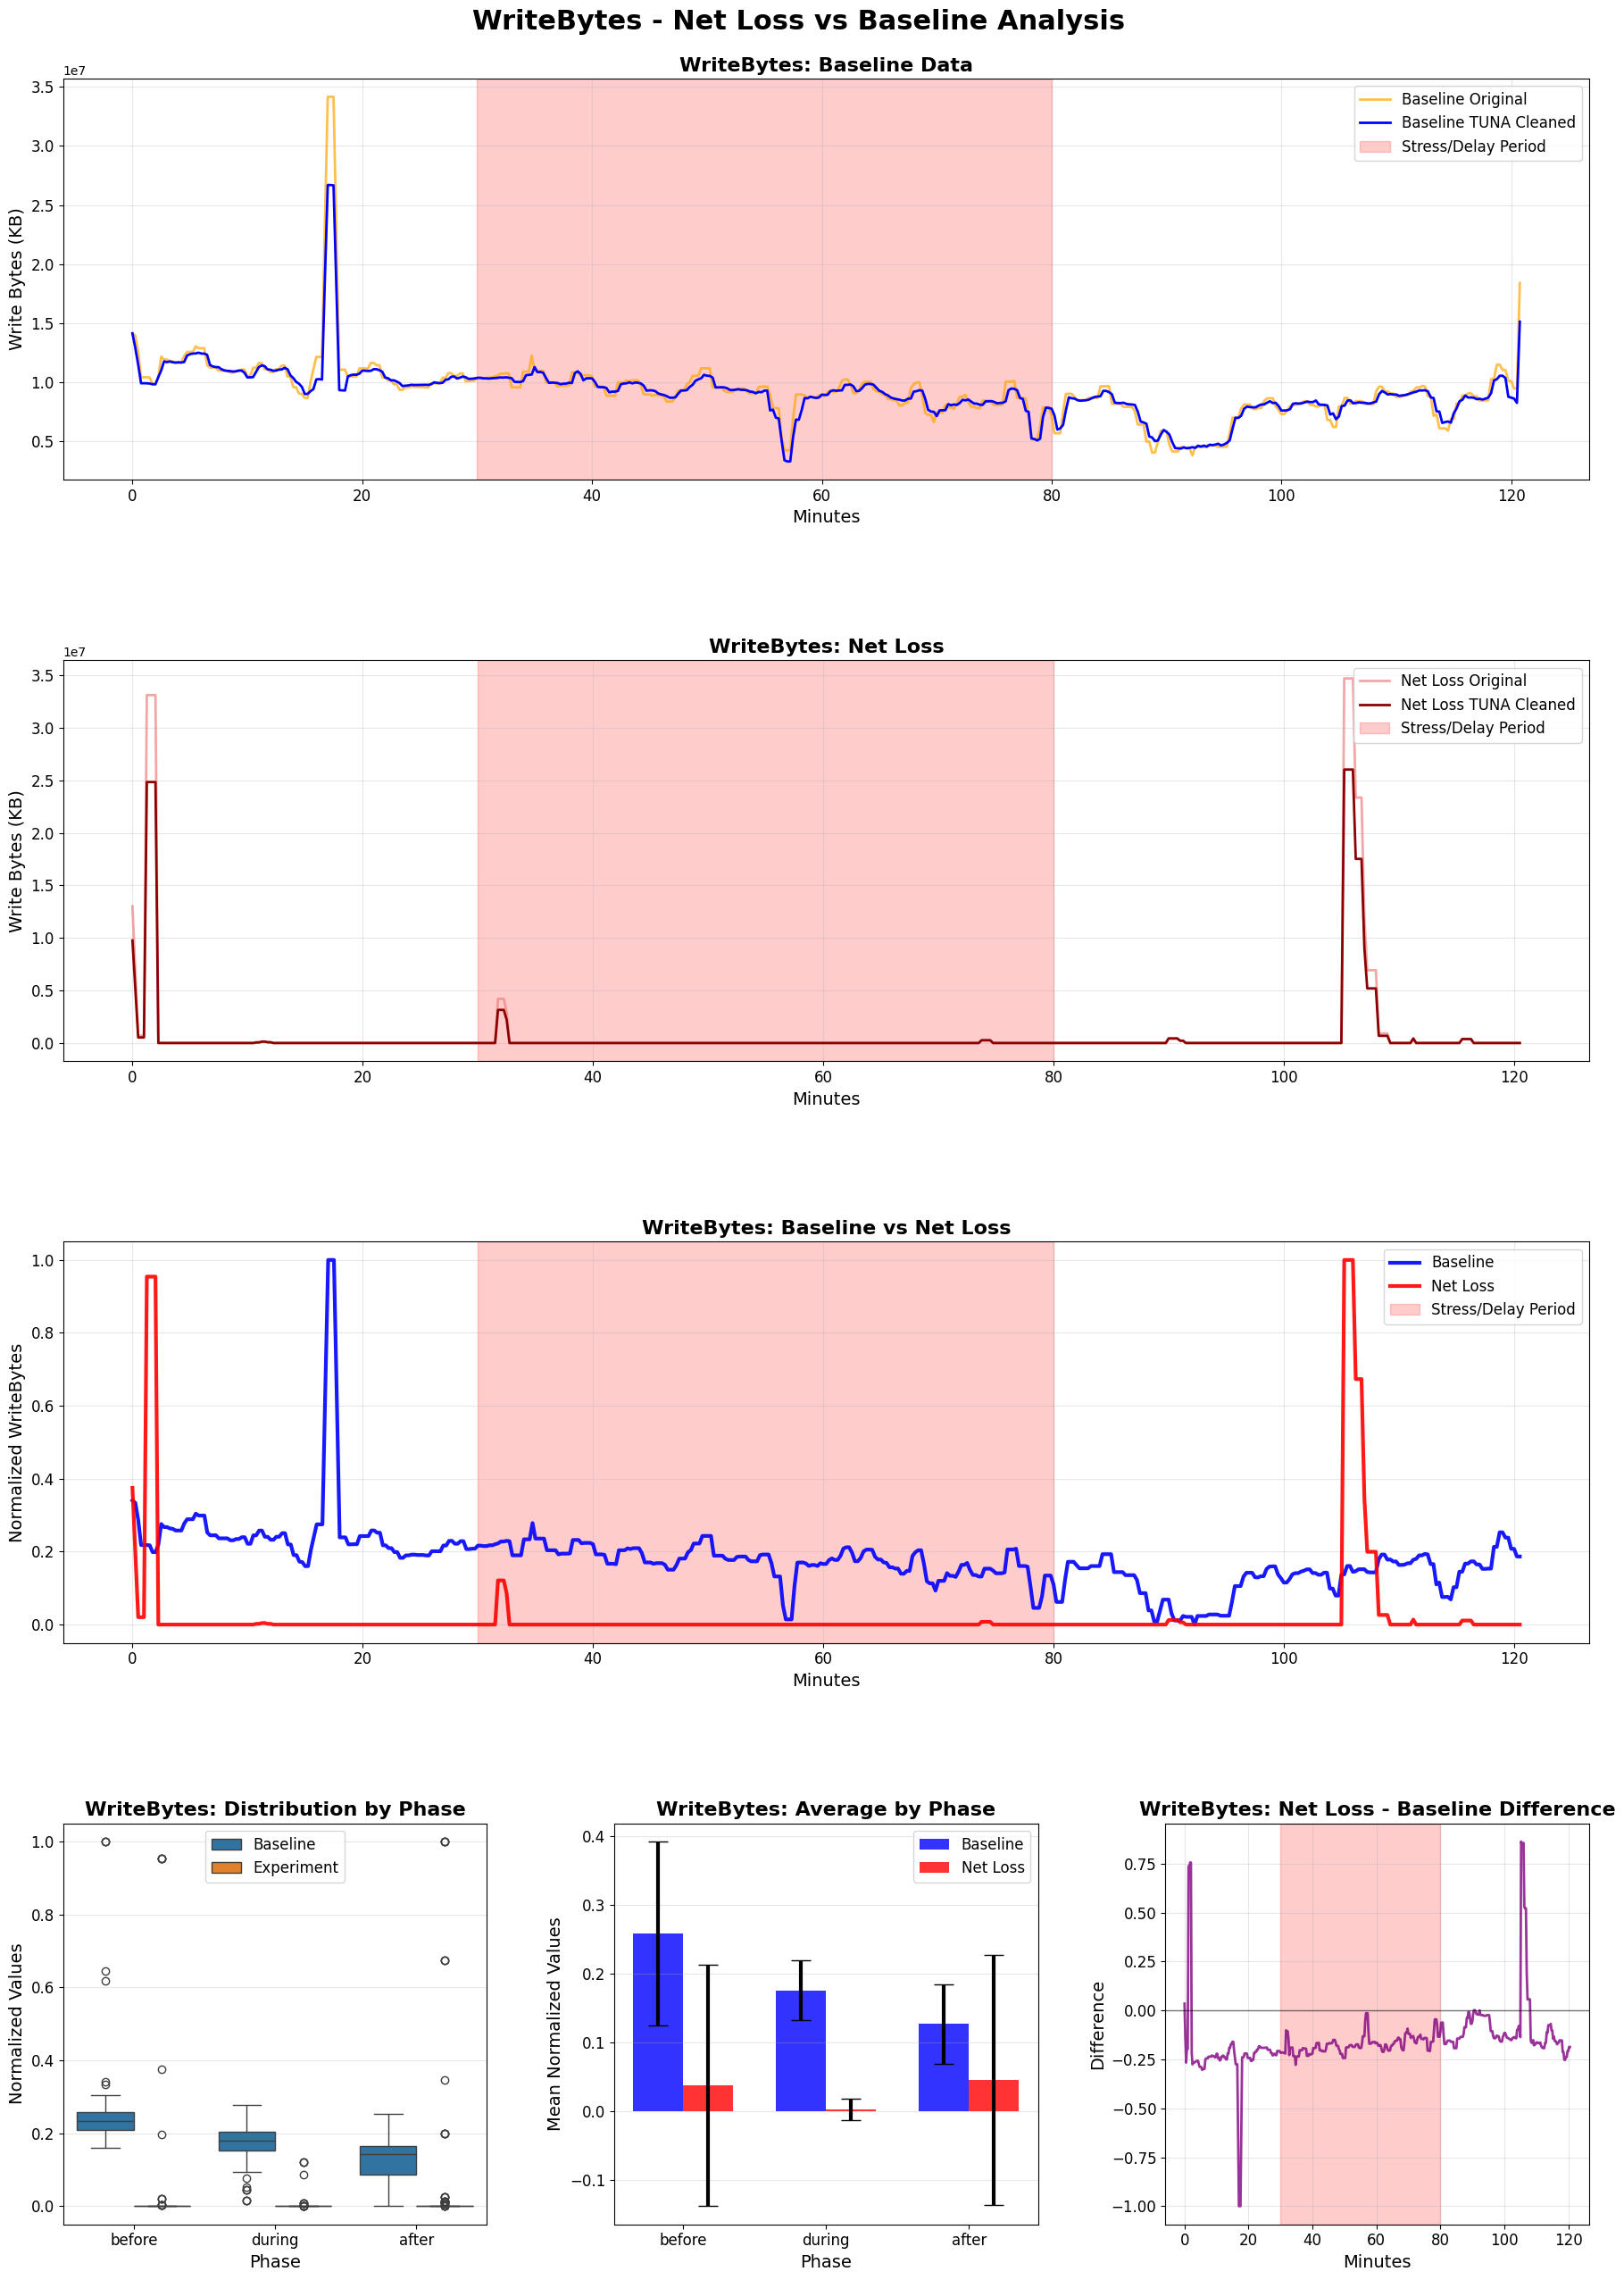


WRITEBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 138 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 83 outliers removed
    Noise Reduction: 19.5%, Correlation: 0.970

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1268  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

NET LOSS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0456  0.1815  0.0  1.0000
before  0.0372  0.1753  0.0  0.9543
during  0.0024  0.0159  0.0  0.1211

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 10.97, p=  0.0000 (SIGNIFICANT)
  DURING  : t= 53.02, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  5.42, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :  -85.59% (DECREASE)
  DURING  :  -98.64% (DECREASE)
  AFTER   :  -64.01% (DECREASE)

DISK I/O METRICS DETAILS:
  Metric: WriteBytes


In [9]:
def calculate_disk_values(df, metric_name):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'BlockLatency':
        return df[value_cols[0]].values
    else:
        return df[value_cols].sum(axis=1).values

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series(np.zeros(len(series)), index=series.index)

def get_y_axis_label(metric_name):
    labels = {
        'BlockLatency': 'Block Latency (ms)',
        'ReadBytes': 'Read Bytes (KB)',
        'WriteBytes': 'Write Bytes (KB)',
        'DiskUtil': 'Disk Utilization (%)',
        'IOPS': 'I/O Operations per Second',
        'ThroughputRead': 'Read Throughput (MB/s)',
        'ThroughputWrite': 'Write Throughput (MB/s)'
    }
    return labels.get(metric_name, 'Disk I/O Value')

def analyze_and_plot_disk_comparison(metric_name, experiment_name, experiment_df, baseline_df, 
                                   tuna_results=None, delay_minutes=30, duration_minutes=50):
    
    experiment_values = calculate_disk_values(experiment_df, metric_name)
    baseline_values = calculate_disk_values(baseline_df, metric_name)
    
    experiment_series = pd.Series(experiment_values, index=experiment_df.index)
    baseline_series = pd.Series(baseline_values, index=baseline_df.index)
    
    experiment_cleaned = None
    baseline_cleaned = None
    if tuna_results and metric_name in tuna_results:
        if experiment_name in tuna_results[metric_name]:
            experiment_cleaned = pd.Series(tuna_results[metric_name][experiment_name]['cleaned'])
        if 'baseline' in tuna_results[metric_name]:
            baseline_cleaned = pd.Series(tuna_results[metric_name]['baseline']['cleaned'])
    
    experiment_norm = normalize_series(experiment_series)
    baseline_norm = normalize_series(baseline_series)
    
    min_length = min(len(experiment_norm), len(baseline_norm), len(experiment_df['Minutes']), len(baseline_df['Minutes']))
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm.iloc[:min_length],
        'Experiment': experiment_norm.iloc[:min_length],
        'Minutes': experiment_df['Minutes'].iloc[:min_length],
        'Baseline_Minutes': baseline_df['Minutes'].iloc[:min_length]
    })
    
    df_combined['difference'] = df_combined['Experiment'] - df_combined['Baseline']
    
    df_combined['phase'] = 'before'
    df_combined.loc[(df_combined['Minutes'] >= delay_minutes) & 
                   (df_combined['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df_combined.loc[df_combined['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    
    stats_baseline = df_combined.groupby('phase')['Baseline'].agg(['mean', 'std', 'min', 'max'])
    stats_experiment = df_combined.groupby('phase')['Experiment'].agg(['mean', 'std', 'min', 'max'])
    
    t_tests = {}
    available_phases = stats_baseline.index.tolist()
    
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            data = df_combined[df_combined['phase'] == phase]
            if len(data) > 1:
                t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['Experiment'].dropna())
                t_tests[phase] = {'t': t_stat, 'p': p_value}
            else:
                t_tests[phase] = {'t': 0, 'p': 1}
        else:
            t_tests[phase] = {'t': 0, 'p': 1, 'note': 'Phase not present in data'}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            baseline_mean = stats_baseline.loc[phase, 'mean']
            experiment_mean = stats_experiment.loc[phase, 'mean']
            if baseline_mean != 0:
                impact[phase] = ((experiment_mean - baseline_mean) / baseline_mean) * 100
            else:
                impact[phase] = 0
        else:
            impact[phase] = 0
    
    fig = plt.figure(figsize=(18, 26))
    
    y_label = get_y_axis_label(metric_name)
    
    plt.subplot(4, 1, 1)
    plt.plot(baseline_df['Minutes'], baseline_series, 
             label='Baseline Original', color='orange', alpha=0.7, linewidth=2)
    
    if baseline_cleaned is not None:
        plt.plot(baseline_df['Minutes'].iloc[:len(baseline_cleaned)], baseline_cleaned, 
                 label='Baseline TUNA Cleaned', linewidth=2, color='blue')
    else:
        plt.plot(baseline_df['Minutes'], baseline_series, 
                 label='Baseline', linewidth=2, color='blue')
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: Baseline Data', fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 2)
    plt.plot(experiment_df['Minutes'], experiment_series, 
             label=f'{experiment_name.replace("_", " ").title()} Original', 
             alpha=0.7, color='lightcoral', linewidth=2)
    
    if experiment_cleaned is not None:
        plt.plot(experiment_df['Minutes'].iloc[:len(experiment_cleaned)], experiment_cleaned, 
                 label=f'{experiment_name.replace("_", " ").title()} TUNA Cleaned', 
                 linewidth=2, color='darkred')
    else:
        plt.plot(experiment_df['Minutes'], experiment_series, 
                 label=f'{experiment_name.replace("_", " ").title()}', 
                 linewidth=2, color='darkred')

    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 3)
    plt.plot(df_combined['Minutes'], df_combined['Baseline'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(df_combined['Minutes'], df_combined['Experiment'], 
             label=f'{experiment_name.replace("_", " ").title()}', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f"{metric_name}: Baseline vs {experiment_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Minutes", fontsize=14)
    plt.ylabel(f"Normalized {metric_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 10)
    box_data = pd.melt(df_combined[['Baseline', 'Experiment', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{metric_name}: Distribution by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 11)
    phases_to_plot = [p for p in ['before', 'during', 'after'] if p in available_phases]
    
    if len(phases_to_plot) > 0:
        x = np.arange(len(phases_to_plot))
        width = 0.35
        
        baseline_means = [stats_baseline.loc[p, 'mean'] for p in phases_to_plot]
        baseline_stds = [stats_baseline.loc[p, 'std'] for p in phases_to_plot]
        experiment_means = [stats_experiment.loc[p, 'mean'] for p in phases_to_plot]
        experiment_stds = [stats_experiment.loc[p, 'std'] for p in phases_to_plot]
        
        bars1 = plt.bar(x - width/2, baseline_means, width, 
                       label='Baseline', alpha=0.8, color='blue')
        bars2 = plt.bar(x + width/2, experiment_means, width, 
                       label=f'{experiment_name.replace("_", " ").title()}', alpha=0.8, color='red')
        
        plt.errorbar(x - width/2, baseline_means, yerr=baseline_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        plt.errorbar(x + width/2, experiment_means, yerr=experiment_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        
        plt.xticks(x, phases_to_plot)
    else:
        plt.text(0.5, 0.5, 'No phase data available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
    
    plt.title(f'{metric_name}: Average by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Mean Normalized Values', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 12)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} - Baseline Difference', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel('Difference', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} - {experiment_name.replace("_", " ").title()} vs Baseline Analysis', 
                fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.45, wspace=0.3)
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"{metric_name.upper()} - {experiment_name.upper().replace('_', ' ')} VS BASELINE ANALYSIS")
    print(f"{'='*80}")
    
    if tuna_results and metric_name in tuna_results:
        print(f"\nTUNA CLEANING SUMMARY:")
        if experiment_name in tuna_results[metric_name]:
            exp_stats = tuna_results[metric_name][experiment_name]['stats']
            print(f"  {experiment_name.upper().replace('_', ' ')}: {exp_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {exp_stats['noise_reduction']:.1f}%, Correlation: {exp_stats['correlation']:.3f}")
        
        if 'baseline' in tuna_results[metric_name]:
            base_stats = tuna_results[metric_name]['baseline']['stats']
            print(f"  BASELINE: {base_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {base_stats['noise_reduction']:.1f}%, Correlation: {base_stats['correlation']:.3f}")

    print(f"\nBASELINE STATISTICS BY PHASE:")
    if len(stats_baseline) > 0:
        print(stats_baseline.round(4))
    else:
        print("  No phase data available")

    print(f"\n{experiment_name.upper().replace('_', ' ')} STATISTICS BY PHASE:")
    if len(stats_experiment) > 0:
        print(stats_experiment.round(4))
    else:
        print("  No phase data available")

    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        if 'note' in test:
            print(f"  {phase.upper():8}: {test['note']}")
        else:
            sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
            print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")

    print(f"\n{experiment_name.upper().replace('_', ' ')} IMPACT:")
    for phase, change in impact.items():
        if change == 0 and phase not in available_phases:
            print(f"  {phase.upper():8}: Phase not present in data")
        else:
            direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
            print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")

    value_cols = [col for col in experiment_df.columns if col not in ['Time', 'Minutes', 'source']]
    print(f"\nDISK I/O METRICS DETAILS:")
    print(f"  Metric: {metric_name}")
    print(f"  Metric type: {y_label}")
    print(f"  Columns analyzed: {value_cols}")
    print(f"  Data points analyzed: {len(df_combined)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_experiment': stats_experiment,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'tuna_info': {
            'experiment_cleaned': experiment_cleaned is not None,
            'baseline_cleaned': baseline_cleaned is not None
        }
    }

def run_comprehensive_disk_analysis(all_datasets, tuna_results=None):
    print(f"\n{'='*80}")
    print("COMPREHENSIVE DISK I/O ANALYSIS")
    print(f"{'='*80}")
    print("Each disk metric will be compared to its own baseline")
    
    analysis_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"\n🔍 Analyzing {metric_name}...")
        analysis_results[metric_name] = {}
        
        baseline_df = experiments['baseline']
        
        for experiment_name, experiment_df in experiments.items():
            if experiment_name != 'baseline':
                print(f"\n📊 Comparing {metric_name}: {experiment_name} stress vs baseline")
                
                result = analyze_and_plot_disk_comparison(
                    metric_name=metric_name,
                    experiment_name=experiment_name,
                    experiment_df=experiment_df,
                    baseline_df=baseline_df,
                    tuna_results=tuna_results
                )
                
                analysis_results[metric_name][experiment_name] = result
    
    return analysis_results

disk_results = run_comprehensive_disk_analysis(all_datasets, tuna_results)